# Analyse des résultats électoraux de la première circonscription de l'isère

Le but de ce travail est de comprendre les reports de voix, les bénéfices de la participation et les effets de scénarios électoraux sur la législative partielle de 2025.

In [826]:
#Importation des packages
!pip install openpyxl
!pip install -U kaleido
!pip install statsmodels

import kaleido
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt 
import plotly.express as px
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import minimize

## Nettoyage des données

Cette partie n'a pas besoin d'être utilisée pour obtenir les données nettoyées, il est possible de les récupérer à la Section Analyse de données.

Avant toute chose, il faut fusionner les données du ministère de l'intérieur pour avoir les résultats à chaque élection (présidentielles 2022 1er tour), législatives anticipées 2024, européennes 2024) pour chaque bureau de vote de la circonscription.

In [627]:
#Importation des données
legi24T1 = pd.read_excel('data/LEGI24T1.xlsx', engine='openpyxl')
legi24T2 = pd.read_excel('data/LEGI24T2.xlsx', engine='openpyxl')

In [260]:
pres22T = pd.read_excel('data/PREZ22.xlsx') 

In [628]:
euro24 = pd.read_excel('data/EURO24.xlsx')

In [ ]:
#On va se restreindre aux bureaux de vote de la circonscription 
#Restriction à l'échelle de l'Isère pour alléger les bases de données 
legi24T1['Code département'] = legi24T1['Code département'].astype(str, errors='ignore')
legi24T138 = legi24T1[legi24T1['Code département'] == '38']

legi24T2['Code département'] = legi24T2['Code département'].astype(str, errors='ignore')
legi24T238 = legi24T2[legi24T2['Code département'] == '38']

euro24['Code département'] = euro24['Code département'].astype(str, errors='ignore')
euro2438 = euro24[euro24['Code département'] == '38']

pres22T['Code du département'] = pres22T['Code du département'].astype(str, errors='ignore')
pres22T138 = pres22T[pres22T['Code du département'] == '38']

In [ ]:
#On vérifie le nombre de bureaux de vote obtenus 
[legi24T138.shape[0], legi24T238.shape[0], euro2438.shape[0], pres22T138.shape[0]]

Le nombre de bureaux de vote a changé entre 2022 et 2024, donc il faudra prendre avec prudence les résultats liant 2022 et 2024. (Il y'a d'ailleurs eu des changements sur la circonscription aussi). 
En effet, ils ne renverront possiblement pas aux mêmes bureaux de vote. Nous ne considérerons donc que les résultats de 2024 pour éviter des erreurs de jointure dans les nomenclatures. 

Nous n'avons pas directement les circonscriptions, nous allons sélectionner les communes puis trier les bureaux de Grenoble pour garder les bureaux de la circonscription.

In [ ]:
liste_communes_circo1 = ['38185', '38229', '38249', '38045', '38126', '38471', '38516', '38039', '38431', '38397']
legi24T138['Code commune'] = legi24T138['Code commune'].astype(str, errors='ignore')
legi24T1_C1 = legi24T138[legi24T138['Code commune'].isin(liste_communes_circo1)]

legi24T238['Code commune'] = legi24T238['Code commune'].astype(str, errors='ignore')
legi24T2_C1 = legi24T238[legi24T238['Code commune'].isin(liste_communes_circo1)]

euro2438['Code commune'] = euro2438['Code commune'].astype(str, errors='ignore')
euro24_C1 = euro2438[euro2438['Code commune'].isin(liste_communes_circo1)]

Pour conserver les bureaux grenoblois, nous avons récupéré les numéros de bureaux de vote déclarés sur https://www.grenoble.fr/2707-bureaux-de-vote.htm en étant associé à la circo 1.

In [ ]:
# Créer un masque pour les lignes à exclure
mask = (
    (legi24T1_C1['Code commune'] == '38185') & 
    (      (legi24T1_C1['Code BV'] < 3) |
        (legi24T1_C1['Code BV'] < 25) &  (legi24T1_C1['Code BV'] > 4)  |
        (legi24T1_C1['Code BV'] > 36) & (legi24T1_C1['Code BV'] < 42) |
        (legi24T1_C1['Code BV'] > 61) & (legi24T1_C1['Code BV'] < 65) |
        (legi24T1_C1['Code BV'] > 73)
    )
)

# Filtrer le DataFrame pour conserver uniquement les lignes qui ne correspondent pas à ce masque
legi24T1_C1 = legi24T1_C1[~mask]

# Créer un masque pour les lignes à exclure
legi24T2_C1['Code BV'] = legi24T2_C1['Code BV'].astype(int) 
mask = (
    (legi24T2_C1['Code commune'] == '38185') & 
    (   (legi24T2_C1['Code BV'] < 3) |
        (legi24T2_C1['Code BV'] < 25)  & (legi24T2_C1['Code BV'] > 4) | 
        (legi24T2_C1['Code BV'] > 36) & (legi24T2_C1['Code BV'] < 42) |
        (legi24T2_C1['Code BV'] > 61) & (legi24T2_C1['Code BV'] < 65) |
        (legi24T2_C1['Code BV'] > 73)
    )
)

# Filtrer le DataFrame pour conserver uniquement les lignes qui ne correspondent pas à ce masque
legi24T2_C1 = legi24T2_C1[~mask]

# Créer un masque pour les lignes à exclure
euro24_C1['Code BV'] = euro24_C1['Code BV'].astype(int)

mask = (
    (euro24_C1['Code commune'] == '38185') & 
    ((euro24_C1['Code BV'] < 3) |
        (euro24_C1['Code BV'] < 25)  & (euro24_C1['Code BV'] > 4 )  |
        (euro24_C1['Code BV'] > 36) & (euro24_C1['Code BV'] < 42) |
        (euro24_C1['Code BV'] > 61) & (euro24_C1['Code BV'] < 65) |
        (euro24_C1['Code BV'] > 73)
    )
)

# Filtrer le DataFrame pour conserver uniquement les lignes qui ne correspondent pas à ce masque
euro24_C1 = euro24_C1[~mask]

Nous allons garder uniquement les colonnes qui nous intéressent dans chaque base de données pour rendre la jointure plus lisible à la fin.

In [ ]:
euro_drop=['Code localisation', 'Libellé localisation', 'Code département', 'Libellé département', 'Libellé commune'] 
num_drop = [f'Numéro de panneau {i}' for i in range(1, 39)] 
libab_drop = [f'Libellé abrégé de liste {i}' for i in range(1, 39)] 
lib_drop = [f'Libellé de liste {i}' for i in range(1, 39)] 
siege_drop = [f'Sièges {i}' for i in range(1, 39)] 

euro_drop = euro_drop + num_drop + libab_drop + lib_drop + siege_drop

euro24_C1_clean = euro24_C1.drop(columns=euro_drop)
euro24_C1_clean

In [217]:
zero_columns = euro24_C1_clean.columns[(euro24_C1_clean == 0).all()]
zero_columns

Index(['Voix 1', 'Voix 2', 'Voix 9', 'Voix 17', 'Voix 36'], dtype='object')

In [218]:
#Nous excluons toutes les colonnes qui impliquent des candidats n'ayant eu aucun vote pour alléger la base euro 
to_drop2=['Nuance liste 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1', 'Nuance liste 2', 'Voix 2', '% Voix/inscrits 2', '% Voix/exprimés 2', 'Nuance liste 9', 'Voix 9', '% Voix/inscrits 9', '% Voix/exprimés 9', 'Nuance liste 36', 'Voix 36', '% Voix/inscrits 36', '% Voix/exprimés 36', 'Nuance liste 17', 'Voix 17', '% Voix/inscrits 17', '% Voix/exprimés 17']
euro24_C1_clean = euro24_C1_clean.drop(columns=to_drop2)
euro24_C1_clean

,Code commune,Code BV,Inscrits,Votants,% Votants,Abstentions,% Abstentions,Exprimés,% Exprimés/inscrits,% Exprimés/votants,...,% Voix/inscrits 35,% Voix/exprimés 35,Nuance liste 37,Voix 37,% Voix/inscrits 37,% Voix/exprimés 37,Nuance liste 38,Voix 38,% Voix/inscrits 38,% Voix/exprimés 38
24666,38039,1,973,610,"62,69%",363,"37,31%",600,"61,66%","98,36%",...,"1,64%","2,67%",LDIV,0,"0,00%","0,00%",LDIV,0,"0,00%","0,00%"
24667,38039,2,996,618,"62,05%",378,"37,95%",611,"61,35%","98,87%",...,"0,90%","1,47%",LDIV,1,"0,10%","0,16%",LDIV,0,"0,00%","0,00%"
24668,38039,3,988,621,"62,85%",367,"37,15%",617,"62,45%","99,36%",...,"1,11%","1,78%",LDIV,0,"0,00%","0,00%",LDIV,0,"0,00%","0,00%"
24675,38045,1,1037,756,"72,90%",281,"27,10%",749,"72,23%","99,07%",...,"1,16%","1,60%",LDIV,1,"0,10%","0,13%",LDIV,0,"0,00%","0,00%"
24676,38045,2,1033,716,"69,31%",317,"30,69%",702,"67,96%","98,04%",...,"0,29%","0,43%",LDIV,0,"0,00%","0,00%",LDIV,0,"0,00%","0,00%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25461,38471,1,1022,724,"70,84%",298,"29,16%",715,"69,96%","98,76%",...,"1,47%","2,10%",LDIV,0,"0,00%","0,00%",LDIV,0,"0,00%","0,00%"
25539,38516,1,1065,637,"59,81%",428,"40,19%",632,"59,34%","99,22%",...,"0,56%","0,95%",LDIV,0,"0,00%","0,00%",LDIV,0,"0,00%","0,00%"
25540,38516,2,1115,767,"68,79%",348,"31,21%",761,"68,25%","99,22%",...,"1,43%","2,10%",LDIV,0,"0,00%","0,00%",LDIV,0,"0,00%","0,00%"
25541,38516,3,1075,644,"59,91%",431,"40,09%",638,"59,35%","99,07%",...,"0,37%","0,63%",LDIV,0,"0,00%","0,00%",LDIV,0,"0,00%","0,00%"


In [219]:
def is_percentage(val):
    return isinstance(val, str) and '%' in val

def convert_percentage(val):
    if is_percentage(val):
        return float(val.replace(',', '.').replace('%', '')) / 100
    return val 

# Convertir toutes les colonnes de pourcentages en valeurs numériques
df_numeric = euro24_C1_clean.applymap(convert_percentage)

numeric_cols = df_numeric.select_dtypes(include='number')

# Identifier les colonnes à exclure (où toutes les valeurs sont < 0,01)
cols_to_drop = numeric_cols.columns[(numeric_cols < 0.015).all()]
cols_to_drop


/tmp/ipykernel_2359/1826210764.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_numeric = euro24_C1_clean.applymap(convert_percentage)


Index(['% Blancs/inscrits', '% Nuls/inscrits', '% Voix/inscrits 10',
       '% Voix/inscrits 12', '% Voix/exprimés 12', '% Voix/inscrits 13',
       '% Voix/inscrits 14', '% Voix/exprimés 14', '% Voix/inscrits 15',
       '% Voix/inscrits 16', '% Voix/exprimés 16', '% Voix/inscrits 19',
       '% Voix/exprimés 19', '% Voix/inscrits 20', '% Voix/exprimés 20',
       '% Voix/inscrits 21', '% Voix/exprimés 21', '% Voix/inscrits 22',
       '% Voix/exprimés 22', '% Voix/inscrits 23', '% Voix/exprimés 23',
       '% Voix/inscrits 24', '% Voix/inscrits 25', '% Voix/exprimés 25',
       '% Voix/inscrits 26', '% Voix/exprimés 26', '% Voix/inscrits 28',
       '% Voix/exprimés 28', '% Voix/inscrits 29', '% Voix/exprimés 29',
       '% Voix/inscrits 30', '% Voix/exprimés 30', '% Voix/inscrits 31',
       '% Voix/exprimés 31', '% Voix/inscrits 32', '% Voix/exprimés 32',
       '% Voix/inscrits 34', '% Voix/exprimés 34', '% Voix/inscrits 37',
       '% Voix/exprimés 37', '% Voix/inscrits 38', '% V

In [220]:
#On retire toutes les listes n'ayant pas excédé les 1.5% de suffrage exprimés dans tous les bureaux de votes 
cols_to_drop = ['% Voix/inscrits 12', '% Voix/exprimés 12', 'Nuance liste 12', 'Voix 12', '% Voix/inscrits 14', '% Voix/exprimés 14', 'Nuance liste 14', 'Voix 14', 
       '% Voix/inscrits 16', '% Voix/exprimés 16', 'Nuance liste 16', 'Voix 16', '% Voix/inscrits 19',
       '% Voix/exprimés 19', 'Nuance liste 19', 'Voix 19', '% Voix/inscrits 20', '% Voix/exprimés 20', 'Nuance liste 20', 'Voix 20', 
       '% Voix/inscrits 21', '% Voix/exprimés 21', 'Nuance liste 21', 'Voix 21', '% Voix/inscrits 22',
       '% Voix/exprimés 22', 'Nuance liste 22', 'Voix 22', '% Voix/inscrits 23', '% Voix/exprimés 23', 'Nuance liste 23', 'Voix 23', '% Voix/inscrits 25', '% Voix/exprimés 25',
                'Nuance liste 25', 'Voix 25', '% Voix/inscrits 26', '% Voix/exprimés 26', 'Nuance liste 26', 'Voix 26', '% Voix/inscrits 28',
       '% Voix/exprimés 28', 'Nuance liste 28', 'Voix 28', '% Voix/inscrits 29', '% Voix/exprimés 29', 'Nuance liste 29', 'Voix 29',
       '% Voix/inscrits 30', '% Voix/exprimés 30', 'Nuance liste 30', 'Voix 30', '% Voix/inscrits 31',
       '% Voix/exprimés 31', 'Nuance liste 31', 'Voix 31', '% Voix/inscrits 32', '% Voix/exprimés 32', 'Nuance liste 32', 'Voix 32',
       '% Voix/inscrits 34', '% Voix/exprimés 34', 'Nuance liste 34', 'Voix 34', '% Voix/inscrits 37',
       '% Voix/exprimés 37', 'Nuance liste 37', 'Voix 37', '% Voix/inscrits 38', '% Voix/exprimés 38', 'Nuance liste 38', 'Voix 38' ]

euro24_C1_clean = euro24_C1_clean.drop(columns=cols_to_drop)
euro24_C1_clean

,Code commune,Code BV,Inscrits,Votants,% Votants,Abstentions,% Abstentions,Exprimés,% Exprimés/inscrits,% Exprimés/votants,...,% Voix/inscrits 27,% Voix/exprimés 27,Nuance liste 33,Voix 33,% Voix/inscrits 33,% Voix/exprimés 33,Nuance liste 35,Voix 35,% Voix/inscrits 35,% Voix/exprimés 35
24666,38039,1,973,610,"62,69%",363,"37,31%",600,"61,66%","98,36%",...,"13,67%","22,17%",LCOM,4,"0,41%","0,67%",LECO,16,"1,64%","2,67%"
24667,38039,2,996,618,"62,05%",378,"37,95%",611,"61,35%","98,87%",...,"13,96%","22,75%",LCOM,3,"0,30%","0,49%",LECO,9,"0,90%","1,47%"
24668,38039,3,988,621,"62,85%",367,"37,15%",617,"62,45%","99,36%",...,"12,75%","20,42%",LCOM,4,"0,40%","0,65%",LECO,11,"1,11%","1,78%"
24675,38045,1,1037,756,"72,90%",281,"27,10%",749,"72,23%","99,07%",...,"13,50%","18,69%",LCOM,4,"0,39%","0,53%",LECO,12,"1,16%","1,60%"
24676,38045,2,1033,716,"69,31%",317,"30,69%",702,"67,96%","98,04%",...,"13,07%","19,23%",LCOM,6,"0,58%","0,85%",LECO,3,"0,29%","0,43%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25461,38471,1,1022,724,"70,84%",298,"29,16%",715,"69,96%","98,76%",...,"16,63%","23,78%",LCOM,4,"0,39%","0,56%",LECO,15,"1,47%","2,10%"
25539,38516,1,1065,637,"59,81%",428,"40,19%",632,"59,34%","99,22%",...,"11,74%","19,78%",LCOM,3,"0,28%","0,47%",LECO,6,"0,56%","0,95%"
25540,38516,2,1115,767,"68,79%",348,"31,21%",761,"68,25%","99,22%",...,"15,87%","23,26%",LCOM,1,"0,09%","0,13%",LECO,16,"1,43%","2,10%"
25541,38516,3,1075,644,"59,91%",431,"40,09%",638,"59,35%","99,07%",...,"12,47%","21,00%",LCOM,10,"0,93%","1,57%",LECO,4,"0,37%","0,63%"


In [221]:
euro24_C1_clean.columns

Index(['Code commune', 'Code BV', 'Inscrits', 'Votants', '% Votants',
       'Abstentions', '% Abstentions', 'Exprimés', '% Exprimés/inscrits',
       '% Exprimés/votants', 'Blancs', '% Blancs/inscrits', '% Blancs/votants',
       'Nuls', '% Nuls/inscrits', '% Nuls/votants', 'Nuance liste 3', 'Voix 3',
       '% Voix/inscrits 3', '% Voix/exprimés 3', 'Nuance liste 4', 'Voix 4',
       '% Voix/inscrits 4', '% Voix/exprimés 4', 'Nuance liste 5', 'Voix 5',
       '% Voix/inscrits 5', '% Voix/exprimés 5', 'Nuance liste 6', 'Voix 6',
       '% Voix/inscrits 6', '% Voix/exprimés 6', 'Nuance liste 7', 'Voix 7',
       '% Voix/inscrits 7', '% Voix/exprimés 7', 'Nuance liste 8', 'Voix 8',
       '% Voix/inscrits 8', '% Voix/exprimés 8', 'Nuance liste 10', 'Voix 10',
       '% Voix/inscrits 10', '% Voix/exprimés 10', 'Nuance liste 11',
       'Voix 11', '% Voix/inscrits 11', '% Voix/exprimés 11',
       'Nuance liste 13', 'Voix 13', '% Voix/inscrits 13',
       '% Voix/exprimés 13', 'Nuance list

In [222]:
#Nous allons renommer les colonnes pour clarifier les nuances auxquelles elles renvoient 
euro_final = pd.DataFrame({
    'Code commune' : euro24_C1_clean['Code commune'],
    'Code BV' : euro24_C1_clean['Code BV'],
    'Inscrits_Euro' : euro24_C1_clean['Inscrits'],
    'Votants_Euro' : euro24_C1_clean['Votants'], 
    '% Votants_Euro' : euro24_C1_clean['% Votants'],
    'Abstention_Euro' : euro24_C1_clean['Abstentions'], 
    '% Abstention_Euro' : euro24_C1_clean['% Abstentions'],
    'Exp_Euro' : euro24_C1_clean['Exprimés'],
    'Blancs_Euro' : euro24_C1_clean['Blancs'],
    'Nuls_Euro' : euro24_C1_clean['Nuls'],
    'Voix_REC_Euro' :  euro24_C1_clean['Voix 3'],
    '% VINSC_REC_Euro' :  euro24_C1_clean['% Voix/inscrits 3'],
    '% VEXP_REC_Euro' :  euro24_C1_clean['% Voix/exprimés 3'],
    'Voix_LFI_Euro' :  euro24_C1_clean['Voix 4'],
    '% VINSC_LFI_Euro' :  euro24_C1_clean['% Voix/inscrits 4'],
    '% VEXP_LFI_Euro' :  euro24_C1_clean['% Voix/exprimés 4'],
    'Voix_RN_Euro' :  euro24_C1_clean['Voix 5'],
    '% VINSC_RN_Euro' :  euro24_C1_clean['% Voix/inscrits 5'],
    '% VEXP_RN_Euro' :  euro24_C1_clean['% Voix/exprimés 5'],
    'Voix_EELV_Euro' :  euro24_C1_clean['Voix 6'],
    '% VINSC_EELV_Euro' :  euro24_C1_clean['% Voix/inscrits 6'],
    '% VEXP_EELV_Euro' :  euro24_C1_clean['% Voix/exprimés 6'],
    'Voix_PALES_Euro' :  euro24_C1_clean['Voix 7'], #Liste Free Palestine
    '% VINSC_PALES_Euro' :  euro24_C1_clean['% Voix/inscrits 7'],
    '% VEXP_PALES_Euro' :  euro24_C1_clean['% Voix/exprimés 7'],
    'Voix_ANIM_Euro' :  euro24_C1_clean['Voix 8'], #Parti animaliste
    '% VINSC_ANIM_Euro' :  euro24_C1_clean['% Voix/inscrits 8'],
    '% VEXP_ANIM_Euro' :  euro24_C1_clean['% Voix/exprimés 8'],
    'Voix_PIRATE_Euro' :  euro24_C1_clean['Voix 10'],
    '% VINSC_PIRATE_Euro' :  euro24_C1_clean['% Voix/inscrits 10'],
    '% VEXP_PIRATE_Euro' :  euro24_C1_clean['% Voix/exprimés 10'],
    'Voix_LREM_Euro' :  euro24_C1_clean['Voix 11'],
    '% VINSC_LREM_Euro' :  euro24_C1_clean['% Voix/inscrits 11'],
    '% VEXP_LREM_Euro' :  euro24_C1_clean['% Voix/exprimés 11'],
    'Voix_EQUI_Euro' :  euro24_C1_clean['Voix 13'], #Equinoxe
    '% VINSC_EQUI_Euro' :  euro24_C1_clean['% Voix/inscrits 13'],
    '% VEXP_EQUI_Euro' :  euro24_C1_clean['% Voix/exprimés 13'],
    'Voix_UPR_Euro' :  euro24_C1_clean['Voix 15'], #Asselineau
    '% VINSC_UPR_Euro' :  euro24_C1_clean['% Voix/inscrits 15'],
    '% VEXP_UPR_Euro' :  euro24_C1_clean['% Voix/exprimés 15'],
    'Voix_LR_Euro' :  euro24_C1_clean['Voix 18'],
    '% VINSC_LR_Euro' :  euro24_C1_clean['% Voix/inscrits 18'],
    '% VEXP_LR_Euro' :  euro24_C1_clean['% Voix/exprimés 18'],
    'Voix_PHIL_Euro' :  euro24_C1_clean['Voix 24'], #Philippot
    '% VINSC_PHIL_Euro' :  euro24_C1_clean['% Voix/inscrits 24'],
    '% VEXP_PHIL_Euro' :  euro24_C1_clean['% Voix/exprimés 24'],
    'Voix_PP_Euro' :  euro24_C1_clean['Voix 27'], #Place Publique
    '% VINSC_PP_Euro' :  euro24_C1_clean['% Voix/inscrits 27'],
    '% VEXP_PP_Euro' :  euro24_C1_clean['% Voix/exprimés 27'],
    'Voix_PCF_Euro' :  euro24_C1_clean['Voix 33'],
    '% VINSC_PCF_Euro' :  euro24_C1_clean['% Voix/inscrits 33'],
    '% VEXP_PCF_Euro' :  euro24_C1_clean['% Voix/exprimés 33'],
    'Voix_ECOC_Euro' :  euro24_C1_clean['Voix 35'], #Ecologie au centre
    '% VINSC_ECOC_Euro' :  euro24_C1_clean['% Voix/inscrits 35'],
    '% VEXP_ECOC_Euro' :  euro24_C1_clean['% Voix/exprimés 35'],
})

In [223]:
euro_final

,Code commune,Code BV,Inscrits_Euro,Votants_Euro,% Votants_Euro,Abstention_Euro,% Abstention_Euro,Exp_Euro,Blancs_Euro,Nuls_Euro,...,% VEXP_PHIL_Euro,Voix_PP_Euro,% VINSC_PP_Euro,% VEXP_PP_Euro,Voix_PCF_Euro,% VINSC_PCF_Euro,% VEXP_PCF_Euro,Voix_ECOC_Euro,% VINSC_ECOC_Euro,% VEXP_ECOC_Euro
24666,38039,1,973,610,"62,69%",363,"37,31%",600,5,5,...,"1,33%",133,"13,67%","22,17%",4,"0,41%","0,67%",16,"1,64%","2,67%"
24667,38039,2,996,618,"62,05%",378,"37,95%",611,2,5,...,"1,47%",139,"13,96%","22,75%",3,"0,30%","0,49%",9,"0,90%","1,47%"
24668,38039,3,988,621,"62,85%",367,"37,15%",617,3,1,...,"0,65%",126,"12,75%","20,42%",4,"0,40%","0,65%",11,"1,11%","1,78%"
24675,38045,1,1037,756,"72,90%",281,"27,10%",749,2,5,...,"0,40%",140,"13,50%","18,69%",4,"0,39%","0,53%",12,"1,16%","1,60%"
24676,38045,2,1033,716,"69,31%",317,"30,69%",702,3,11,...,"1,00%",135,"13,07%","19,23%",6,"0,58%","0,85%",3,"0,29%","0,43%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25461,38471,1,1022,724,"70,84%",298,"29,16%",715,5,4,...,"0,56%",170,"16,63%","23,78%",4,"0,39%","0,56%",15,"1,47%","2,10%"
25539,38516,1,1065,637,"59,81%",428,"40,19%",632,3,2,...,"0,95%",125,"11,74%","19,78%",3,"0,28%","0,47%",6,"0,56%","0,95%"
25540,38516,2,1115,767,"68,79%",348,"31,21%",761,5,1,...,"0,39%",177,"15,87%","23,26%",1,"0,09%","0,13%",16,"1,43%","2,10%"
25541,38516,3,1075,644,"59,91%",431,"40,09%",638,3,3,...,"0,63%",134,"12,47%","21,00%",10,"0,93%","1,57%",4,"0,37%","0,63%"


In [224]:
legi24T1_C1 = legi24T1_C1.dropna(how='all', inplace=False, axis=1)
legi24T1_C1.columns

Index(['Code département', 'Libellé département', 'Code commune',
       'Libellé commune', 'Code BV', 'Inscrits', 'Votants', '% Votants',
       'Abstentions', '% Abstentions', 'Exprimés', '% Exprimés/inscrits',
       '% Exprimés/votants', 'Blancs', '% Blancs/inscrits', '% Blancs/votants',
       'Nuls', '% Nuls/inscrits', '% Nuls/votants', 'Numéro de panneau 1',
       'Nuance candidat 1', 'Nom candidat 1', 'Prénom candidat 1',
       'Sexe candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1',
       'Numéro de panneau 2', 'Nuance candidat 2', 'Nom candidat 2',
       'Prénom candidat 2', 'Sexe candidat 2', 'Voix 2', '% Voix/inscrits 2',
       '% Voix/exprimés 2', 'Numéro de panneau 3', 'Nuance candidat 3',
       'Nom candidat 3', 'Prénom candidat 3', 'Sexe candidat 3', 'Voix 3',
       '% Voix/inscrits 3', '% Voix/exprimés 3', 'Numéro de panneau 4',
       'Nuance candidat 4', 'Nom candidat 4', 'Prénom candidat 4',
       'Sexe candidat 4', 'Voix 4', '% Voix/inscrits 4

In [225]:
legi24T1_C1 = legi24T1_C1[['Code commune', 'Libellé commune', 'Code BV', 'Inscrits', 'Votants', '% Votants',
       'Abstentions', '% Abstentions', 'Exprimés', 'Blancs', 'Nuls', 'Nuance candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1', 'Nuance candidat 2', 'Voix 2', '% Voix/inscrits 2', '% Voix/exprimés 2', 'Nuance candidat 3', 'Voix 3', '% Voix/inscrits 3', '% Voix/exprimés 3', 'Nuance candidat 4', 'Voix 4', '% Voix/inscrits 4', '% Voix/exprimés 4','Nuance candidat 5', 'Voix 5', '% Voix/inscrits 5', '% Voix/exprimés 5']]

In [226]:
legi24T1_C1.columns

Index(['Code commune', 'Libellé commune', 'Code BV', 'Inscrits', 'Votants',
       '% Votants', 'Abstentions', '% Abstentions', 'Exprimés', 'Blancs',
       'Nuls', 'Nuance candidat 1', 'Voix 1', '% Voix/inscrits 1',
       '% Voix/exprimés 1', 'Nuance candidat 2', 'Voix 2', '% Voix/inscrits 2',
       '% Voix/exprimés 2', 'Nuance candidat 3', 'Voix 3', '% Voix/inscrits 3',
       '% Voix/exprimés 3', 'Nuance candidat 4', 'Voix 4', '% Voix/inscrits 4',
       '% Voix/exprimés 4', 'Nuance candidat 5', 'Voix 5', '% Voix/inscrits 5',
       '% Voix/exprimés 5'],
      dtype='object')

In [228]:
legit1_final = pd.DataFrame({
    'Code commune' : legi24T1_C1['Code commune'],
    'Libellé commune' : legi24T1_C1['Libellé commune'],
    'Code BV' : legi24T1_C1['Code BV'],
    'Inscrits_LegiT1' : legi24T1_C1['Inscrits'], 
    'Votants_LegiT1' : legi24T1_C1['Votants'], 
    '% Votants_LegiT1' : legi24T1_C1['% Votants'], 
    'Abstention_LegiT1' : legi24T1_C1['Abstentions'], 
    '% Abstentions_LegiT1' : legi24T1_C1['% Abstentions'],
    'Exprimés_LegiT1' : legi24T1_C1['Exprimés'],
    'Blancs_LegiT1' : legi24T1_C1['Blancs'],
    'Nuls_LegiT1' : legi24T1_C1['Nuls'],
    'Voix_LR_LegiT1' : legi24T1_C1['Voix 1'], 
    '% VINSC_LR_LegiT1' : legi24T1_C1['% Voix/inscrits 1'], 
    '% VEXP_LR_LegiT1' : legi24T1_C1['% Voix/exprimés 1'], 
     'Voix_LO_LegiT1' : legi24T1_C1['Voix 2'], 
    '% VINSC_LO_LegiT1' : legi24T1_C1['% Voix/inscrits 2'], 
    '% VEXP_LO_LegiT1' : legi24T1_C1['% Voix/exprimés 2'], 
     'Voix_UXD_LegiT1' : legi24T1_C1['Voix 3'], 
    '% VINSC_UXD_LegiT1' : legi24T1_C1['% Voix/inscrits 3'], 
    '% VEXP_UXD_LegiT1' : legi24T1_C1['% Voix/exprimés 3'], 
     'Voix_UG_LegiT1' : legi24T1_C1['Voix 4'], 
    '% VINSC_UG_LegiT1' : legi24T1_C1['% Voix/inscrits 4'], 
    '% VEXP_UG_LegiT1' : legi24T1_C1['% Voix/exprimés 4'], 
     'Voix_LREM_LegiT1' : legi24T1_C1['Voix 5'], 
    '% VINSC_LREM_LegiT1' : legi24T1_C1['% Voix/inscrits 5'], 
    '% VEXP_LREM_LegiT1' : legi24T1_C1['% Voix/exprimés 5'], 
})

In [229]:
legit1_final

,Code commune,Libellé commune,Code BV,Inscrits_LegiT1,Votants_LegiT1,% Votants_LegiT1,Abstention_LegiT1,% Abstentions_LegiT1,Exprimés_LegiT1,Blancs_LegiT1,...,% VEXP_LO_LegiT1,Voix_UXD_LegiT1,% VINSC_UXD_LegiT1,% VEXP_UXD_LegiT1,Voix_UG_LegiT1,% VINSC_UG_LegiT1,% VEXP_UG_LegiT1,Voix_LREM_LegiT1,% VINSC_LREM_LegiT1,% VEXP_LREM_LegiT1
24667,38039,Bernin,1,965,754,"78,13%",211,"21,87%",741,10,...,"1,89%",163,"16,89%","22,00%",186,"19,27%","25,10%",331.0,"34,30%","44,67%"
24668,38039,Bernin,2,992,778,"78,43%",214,"21,57%",771,4,...,"0,78%",162,"16,33%","21,01%",197,"19,86%","25,55%",334.0,"33,67%","43,32%"
24669,38039,Bernin,3,980,745,"76,02%",235,"23,98%",738,4,...,"0,54%",189,"19,29%","25,61%",185,"18,88%","25,07%",310.0,"31,63%","42,01%"
24676,38045,Biviers,1,1036,845,"81,56%",191,"18,44%",837,7,...,"0,12%",166,"16,02%","19,83%",164,"15,83%","19,59%",419.0,"40,44%","50,06%"
24677,38045,Biviers,2,1032,826,"80,04%",206,"19,96%",820,4,...,"0,61%",209,"20,25%","25,49%",168,"16,28%","20,49%",369.0,"35,76%","45,00%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25462,38471,Le Sappey-en-Chartreuse,1,1009,841,"83,35%",168,"16,65%",832,8,...,"1,32%",104,"10,31%","12,50%",433,"42,91%","52,04%",246.0,"24,38%","29,57%"
25540,38516,La Tronche,1,1070,771,"72,06%",299,"27,94%",759,11,...,"1,19%",132,"12,34%","17,39%",310,"28,97%","40,84%",256.0,"23,93%","33,73%"
25541,38516,La Tronche,2,1103,906,"82,14%",197,"17,86%",889,12,...,"0,56%",118,"10,70%","13,27%",305,"27,65%","34,31%",385.0,"34,90%","43,31%"
25542,38516,La Tronche,3,1069,769,"71,94%",300,"28,06%",766,3,...,"0,78%",129,"12,07%","16,84%",334,"31,24%","43,60%",237.0,"22,17%","30,94%"


In [230]:
legi24T2_C1 = legi24T2_C1.dropna(how='all', inplace=False, axis=1)
legi24T2_C1.columns

Index(['Code département', 'Libellé département', 'Code commune',
       'Libellé commune', 'Code BV', 'Inscrits', 'Votants', '% Votants',
       'Abstentions', '% Abstentions', 'Exprimés', '% Exprimés/inscrits',
       '% Exprimés/votants', 'Blancs', '% Blancs/inscrits', '% Blancs/votants',
       'Nuls', '% Nuls/inscrits', '% Nuls/votants', 'Numéro de panneau 1',
       'Nuance candidat 1', 'Nom candidat 1', 'Prénom candidat 1',
       'Sexe candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1',
       'Numéro de panneau 2', 'Nuance candidat 2', 'Nom candidat 2',
       'Prénom candidat 2', 'Sexe candidat 2', 'Voix 2', '% Voix/inscrits 2',
       '% Voix/exprimés 2', 'Elu 2', 'Numéro de panneau 3',
       'Nuance candidat 3', 'Nom candidat 3', 'Prénom candidat 3',
       'Sexe candidat 3', 'Voix 3', '% Voix/inscrits 3', '% Voix/exprimés 3'],
      dtype='object')

In [231]:
legit2_final = pd.DataFrame({
    'Code commune' : legi24T2_C1['Code commune'],
    'Code BV' : legi24T2_C1['Code BV'],
    'Inscrits_LegiT2' : legi24T2_C1['Inscrits'], 
    'Votants_LegiT2' : legi24T2_C1['Votants'], 
    '% Votants_LegiT2' : legi24T2_C1['% Votants'], 
    'Abstention_LegiT2' : legi24T2_C1['Abstentions'], 
    '% Abstentions_LegiT2' : legi24T2_C1['% Abstentions'],
    'Exprimés_LegiT2' : legi24T2_C1['Exprimés'],
    'Blancs_LegiT2' : legi24T2_C1['Blancs'],
    'Nuls_LegiT2' : legi24T2_C1['Nuls'],
    'Voix_LREM_LegiT2' : legi24T2_C1['Voix 3'], 
    '% VINSC_LREM_LegiT2' : legi24T2_C1['% Voix/inscrits 3'], 
    '% VEXP_LREM_LegiT2' : legi24T2_C1['% Voix/exprimés 3'], 
     'Voix_UG_LegiT2' : legi24T2_C1['Voix 2'], 
    '% VINSC_UG_LegiT2' : legi24T2_C1['% Voix/inscrits 2'], 
    '% VEXP_UG_LegiT2' : legi24T2_C1['% Voix/exprimés 2'], 
     'Voix_UXD_LegiT2' : legi24T2_C1['Voix 1'], 
    '% VINSC_UXD_LegiT2' : legi24T2_C1['% Voix/inscrits 1'], 
    '% VEXP_UXD_LegiT2' : legi24T2_C1['% Voix/exprimés 1'], 
})

In [232]:
legit2_final

,Code commune,Code BV,Inscrits_LegiT2,Votants_LegiT2,% Votants_LegiT2,Abstention_LegiT2,% Abstentions_LegiT2,Exprimés_LegiT2,Blancs_LegiT2,Nuls_LegiT2,Voix_LREM_LegiT2,% VINSC_LREM_LegiT2,% VEXP_LREM_LegiT2,Voix_UG_LegiT2,% VINSC_UG_LegiT2,% VEXP_UG_LegiT2,Voix_UXD_LegiT2,% VINSC_UXD_LegiT2,% VEXP_UXD_LegiT2
22263,38039,1,965,739,"76,58%",226,"23,42%",720,16,3,377.0,"39,07%","52,36%",193.0,"20,00%","26,81%",150,"15,54%","20,83%"
22264,38039,2,992,804,"81,05%",188,"18,95%",791,8,5,425.0,"42,84%","53,73%",206.0,"20,77%","26,04%",160,"16,13%","20,23%"
22265,38039,3,980,741,"75,61%",239,"24,39%",727,10,4,357.0,"36,43%","49,11%",188.0,"19,18%","25,86%",182,"18,57%","25,03%"
22272,38045,1,1037,844,"81,39%",193,"18,61%",835,7,2,501.0,"48,31%","60,00%",166.0,"16,01%","19,88%",168,"16,20%","20,12%"
22273,38045,2,1032,822,"79,65%",210,"20,35%",815,5,2,452.0,"43,80%","55,46%",168.0,"16,28%","20,61%",195,"18,90%","23,93%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,38471,1,1010,854,"84,55%",156,"15,45%",841,12,1,285.0,"28,22%","33,89%",440.0,"43,56%","52,32%",116,"11,49%","13,79%"
23136,38516,1,1070,758,"70,84%",312,"29,16%",741,5,12,305.0,"28,50%","41,16%",327.0,"30,56%","44,13%",109,"10,19%","14,71%"
23137,38516,2,1103,906,"82,14%",197,"17,86%",889,16,1,467.0,"42,34%","52,53%",318.0,"28,83%","35,77%",104,"9,43%","11,70%"
23138,38516,3,1068,763,"71,44%",305,"28,56%",751,9,3,288.0,"26,97%","38,35%",334.0,"31,27%","44,47%",129,"12,08%","17,18%"


Nous allons vérifier que chaque base de donnée renvoie les bons scores pour voir si on a pas fait d'erreur

Sources européennes : https://www.lemonde.fr/les-decodeurs/article/2024/06/12/en-cartes-les-resultats-des-europeennes-projetes-dans-les-577-circonscriptions-legislatives_6239173_4355770.html

Législatives : https://www.ouest-france.fr/elections/resultats/isere/1ere-circonscription/

In [233]:
#vérification européennes
Total = euro_final["Voix_PP_Euro"].sum()
print("Place Publique:", Total)
Total = euro_final["Voix_LREM_Euro"].sum()
print("Renaissance:", Total)
Total = euro_final["Voix_RN_Euro"].sum()
print("RN:", Total)
Total = euro_final["Voix_LFI_Euro"].sum()
print("LFI:", Total)
Total = euro_final["Voix_EELV_Euro"].sum()
print("EELV:", Total)

Place Publique: 11279
Renaissance: 9288
RN: 7626
LFI: 7116
EELV: 6298


In [234]:
#Vérification T1 législatives
Total = legit1_final["Voix_UG_LegiT1"].sum()
print("NFP:", Total)
Total = legit1_final["Voix_LREM_LegiT1"].sum()
print("LREM:", Total)
Total = legit1_final["Voix_UXD_LegiT1"].sum()
print("UXD:", Total)
Total = legit1_final["Voix_LR_LegiT1"].sum()
print("LR:", Total)
Total = legit1_final["Voix_LO_LegiT1"].sum()
print("LO:", Total)

NFP: 25207
LREM: 21089.0
UXD: 11504
LR: 4379
LO: 541


In [235]:
#Vérification T2 législatives
Total = legit2_final["Voix_UG_LegiT2"].sum()
print("NFP:", Total)
Total = legit2_final["Voix_LREM_LegiT2"].sum()
print("LREM:", Total)
Total = legit2_final["Voix_UXD_LegiT2"].sum()
print("UXD:", Total)

NFP: 26438.0
LREM: 25120.0
UXD: 10865


Nous allons créer un code unique de bureau de vote (reposant sur la fusion des codes communes et des numéros de bureau) afin de fusionner les résultats des bureaux de vote dans une même base de données.

In [236]:
#Adaptation pour des codes à 4 chiffres de numéro de bureau de vote
legit1_final['Code BV'] = legit1_final['Code BV'].astype(str).str.zfill(4)
legit2_final['Code BV'] = legit2_final['Code BV'].astype(str).str.zfill(4)
euro_final['Code BV'] = euro_final['Code BV'].astype(str).str.zfill(4)

#Conversion des colonnes en chaines de caractères des codes communes et numéro de bureveau de vote
legit1_final['Code BV'] = legit1_final['Code BV'].astype(str)
legit1_final['Code commune'] = legit1_final['Code commune'].astype(str)
legit2_final['Code BV'] = legit2_final['Code BV'].astype(str)
legit2_final['Code commune'] = legit2_final['Code commune'].astype(str)
euro_final['Code BV'] = euro_final['Code BV'].astype(str)
euro_final['Code commune'] = euro_final['Code commune'].astype(str)

#On somme les chaines de caractère pour créer un identifiant unique
legit1_final['id_bv'] = legit1_final['Code commune'].astype(str) + legit1_final['Code BV'].astype(str)
legit2_final['id_bv'] = legit2_final['Code commune'].astype(str) + legit2_final['Code BV'].astype(str)
euro_final['id_bv'] = euro_final['Code commune'].astype(str) + euro_final['Code BV'].astype(str)

In [237]:
#Jointures 
final_df = pd.merge(legit1_final, legit2_final, on='id_bv')
final_df = final_df.merge(euro_final, on='id_bv')

In [238]:
#Suppression de colonnes inutiles 
final_df.columns

to_drop = ['Code commune_x', 'Code BV_x', 'Code commune_y', 'Code BV_y', 'Code BV']

final_df = final_df.drop(columns=to_drop)
final_df

,Libellé commune,Inscrits_LegiT1,Votants_LegiT1,% Votants_LegiT1,Abstention_LegiT1,% Abstentions_LegiT1,Exprimés_LegiT1,Blancs_LegiT1,Nuls_LegiT1,Voix_LR_LegiT1,...,% VEXP_PHIL_Euro,Voix_PP_Euro,% VINSC_PP_Euro,% VEXP_PP_Euro,Voix_PCF_Euro,% VINSC_PCF_Euro,% VEXP_PCF_Euro,Voix_ECOC_Euro,% VINSC_ECOC_Euro,% VEXP_ECOC_Euro
0,Bernin,965,754,"78,13%",211,"21,87%",741,10,3,47,...,"1,33%",133,"13,67%","22,17%",4,"0,41%","0,67%",16,"1,64%","2,67%"
1,Bernin,992,778,"78,43%",214,"21,57%",771,4,3,72,...,"1,47%",139,"13,96%","22,75%",3,"0,30%","0,49%",9,"0,90%","1,47%"
2,Bernin,980,745,"76,02%",235,"23,98%",738,4,3,50,...,"0,65%",126,"12,75%","20,42%",4,"0,40%","0,65%",11,"1,11%","1,78%"
3,Biviers,1036,845,"81,56%",191,"18,44%",837,7,1,87,...,"0,40%",140,"13,50%","18,69%",4,"0,39%","0,53%",12,"1,16%","1,60%"
4,Biviers,1032,826,"80,04%",206,"19,96%",820,4,2,69,...,"1,00%",135,"13,07%","19,23%",6,"0,58%","0,85%",3,"0,29%","0,43%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Le Sappey-en-Chartreuse,1009,841,"83,35%",168,"16,65%",832,8,1,38,...,"0,56%",170,"16,63%","23,78%",4,"0,39%","0,56%",15,"1,47%","2,10%"
83,La Tronche,1070,771,"72,06%",299,"27,94%",759,11,1,52,...,"0,95%",125,"11,74%","19,78%",3,"0,28%","0,47%",6,"0,56%","0,95%"
84,La Tronche,1103,906,"82,14%",197,"17,86%",889,12,5,76,...,"0,39%",177,"15,87%","23,26%",1,"0,09%","0,13%",16,"1,43%","2,10%"
85,La Tronche,1069,769,"71,94%",300,"28,06%",766,3,0,60,...,"0,63%",134,"12,47%","21,00%",10,"0,93%","1,57%",4,"0,37%","0,63%"


In [239]:
#Replacer id_bv en deuxième position pour avoir les identifiants au début 
# Définir l'ordre souhaité pour les colonnes
cols = ['Libellé commune', 'Code commune', 'id_bv'] + [col for col in final_df.columns if col != 'Libellé commune' and col != 'id_bv' and col !='Code commune']

# Réorganiser le DataFrame selon cet ordre
final_df = final_df[cols]
final_df

,Libellé commune,Code commune,id_bv,Inscrits_LegiT1,Votants_LegiT1,% Votants_LegiT1,Abstention_LegiT1,% Abstentions_LegiT1,Exprimés_LegiT1,Blancs_LegiT1,...,% VEXP_PHIL_Euro,Voix_PP_Euro,% VINSC_PP_Euro,% VEXP_PP_Euro,Voix_PCF_Euro,% VINSC_PCF_Euro,% VEXP_PCF_Euro,Voix_ECOC_Euro,% VINSC_ECOC_Euro,% VEXP_ECOC_Euro
0,Bernin,38039,380390001,965,754,"78,13%",211,"21,87%",741,10,...,"1,33%",133,"13,67%","22,17%",4,"0,41%","0,67%",16,"1,64%","2,67%"
1,Bernin,38039,380390002,992,778,"78,43%",214,"21,57%",771,4,...,"1,47%",139,"13,96%","22,75%",3,"0,30%","0,49%",9,"0,90%","1,47%"
2,Bernin,38039,380390003,980,745,"76,02%",235,"23,98%",738,4,...,"0,65%",126,"12,75%","20,42%",4,"0,40%","0,65%",11,"1,11%","1,78%"
3,Biviers,38045,380450001,1036,845,"81,56%",191,"18,44%",837,7,...,"0,40%",140,"13,50%","18,69%",4,"0,39%","0,53%",12,"1,16%","1,60%"
4,Biviers,38045,380450002,1032,826,"80,04%",206,"19,96%",820,4,...,"1,00%",135,"13,07%","19,23%",6,"0,58%","0,85%",3,"0,29%","0,43%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Le Sappey-en-Chartreuse,38471,384710001,1009,841,"83,35%",168,"16,65%",832,8,...,"0,56%",170,"16,63%","23,78%",4,"0,39%","0,56%",15,"1,47%","2,10%"
83,La Tronche,38516,385160001,1070,771,"72,06%",299,"27,94%",759,11,...,"0,95%",125,"11,74%","19,78%",3,"0,28%","0,47%",6,"0,56%","0,95%"
84,La Tronche,38516,385160002,1103,906,"82,14%",197,"17,86%",889,12,...,"0,39%",177,"15,87%","23,26%",1,"0,09%","0,13%",16,"1,43%","2,10%"
85,La Tronche,38516,385160003,1069,769,"71,94%",300,"28,06%",766,3,...,"0,63%",134,"12,47%","21,00%",10,"0,93%","1,57%",4,"0,37%","0,63%"


In [240]:
#Revérifications de conformité des scores
Total = final_df["Voix_PP_Euro"].sum()
print("Place Publique EURO:", Total)
Total = final_df["Voix_LREM_Euro"].sum()
print("Renaissance EURO:", Total)
Total = final_df["Voix_RN_Euro"].sum()
print("RN EURO:", Total)
Total = final_df["Voix_LFI_Euro"].sum()
print("LFI EURO:", Total)
Total = final_df["Voix_EELV_Euro"].sum()
print("EELV EURO:", Total)

Total = final_df["Voix_UG_LegiT1"].sum()
print("NFP LT1:", Total)
Total = final_df["Voix_LREM_LegiT1"].sum()
print("LREM LT1:", Total)
Total = final_df["Voix_UXD_LegiT1"].sum()
print("UXD Lt1:", Total)

Total = final_df["Voix_UG_LegiT2"].sum()
print("NFP LT2:", Total)
Total = final_df["Voix_LREM_LegiT2"].sum()
print("LREM LT2:", Total)
Total = final_df["Voix_UXD_LegiT2"].sum()
print("UXD LT2:", Total)

Place Publique EURO: 11279
Renaissance EURO: 9288
RN EURO: 7626
LFI EURO: 7116
EELV EURO: 6298
NFP LT1: 25207
LREM LT1: 21089.0
UXD Lt1: 11504
NFP LT2: 26438.0
LREM LT2: 25120.0
UXD LT2: 10865


In [241]:
#On exporte pour avoir une base de données utilisable 
final_df.to_excel('data/transformed/Circo3801_Scores2024.xlsx', index=False)

## Analyse des dynamiques de 2024 

L'objectif est de comprendre les dynamiques de 2024 avant de se lancer dans des projections. On va essayer d'analyser les éléments suivants : 

- Les reports de voix entre européennes et législatives pour les électeurs de la liste PS-PP (score important dans la circonscription)
- Analyse d'un éventuel gain de participation et de à qui il a profité

In [827]:
#Importation des données électorales de la circo
df = pd.read_excel('data/transformed/Circo3801_Scores2024.xlsx')

### Informations préliminaires
Le nombre d'inscrits a pu légèrement varier 

In [828]:
manip = df.copy() #Copie de la dataframe pour créer des nouvelles colonnes utiles à nos analyses sans modifier df initial qui nous intéresse

manip['diff Euro_legiT1'] = df['Inscrits_Euro'] - df['Inscrits_LegiT1'] #Diff Legi T1 et européennes
manip['diff LEGI_E2T'] = df['Inscrits_LegiT1'] - df['Inscrits_LegiT2'] #Diff enter-deux-tours

manip[['diff Euro_legiT1', 'diff LEGI_E2T']].describe()

,diff Euro_legiT1,diff LEGI_E2T
count,87.000000,87.000000
mean,2.172414,-0.770115
std,6.206161,1.647416
min,-15.000000,-8.000000
25%,-1.000000,-1.000000
50%,3.000000,0.000000
75%,6.000000,0.000000
max,14.000000,2.000000


L'écart reste léger. On va regarder si les bureaux de vote ont un nombre de votants assez proche (on prendra les législatives au premier tour)

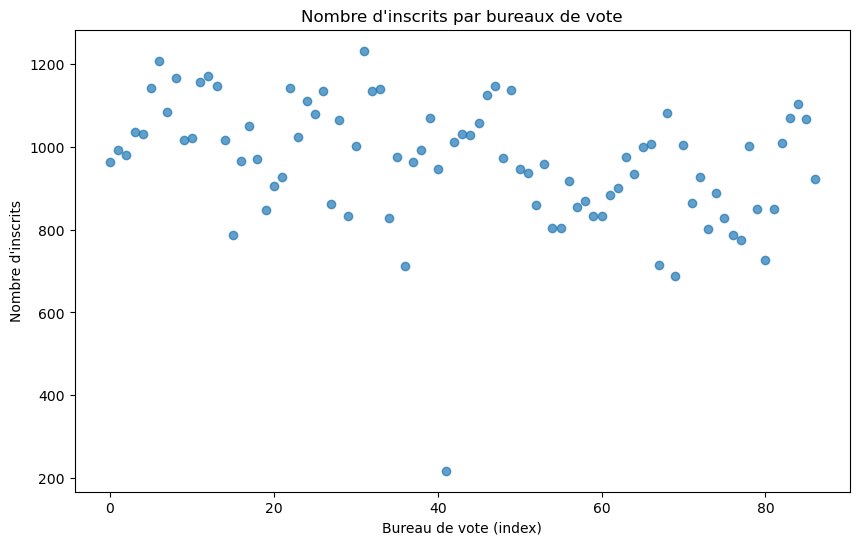

In [829]:
x_values = np.arange(0, len(df), 1)
# Créer le nuage de points
plt.figure(figsize=(10, 6))
plt.scatter(x_values, df['Inscrits_LegiT1'], alpha=0.7)
plt.xlabel("Bureau de vote (index)")
plt.ylabel("Nombre d'inscrits")
plt.title("Nombre d'inscrits par bureaux de vote")
plt.savefig('graphiques/inscrits_par_bv_nbr.jpg')
plt.show()

Un bureau a des scores plus faibles, c'est le bureau "Hotel de Ville 3' qui concerne des dispositions électorales particulières (militaires, français établis hors de France). Ce n'est pas fondé sur la carte électorale classique. Sinon, on observe entre 800 et 1200 électeurs par bureaux de vote, il faudra en tenir compte dans les analyses statistiques : chaque bureau de vote n'ayant pas le même poids dans les élections. 

### Brève description des bureaux de vote

In [830]:
#Conversion des pourcentages en proportion de votes 
def is_percentage(val):
    return isinstance(val, str) and '%' in val

def convert_percentage(val):
    if is_percentage(val):
        return float(val.replace(',', '.').replace('%', ''))
    return val 

# Convertir toutes les colonnes de pourcentages en valeurs numériques
df = df.map(convert_percentage)

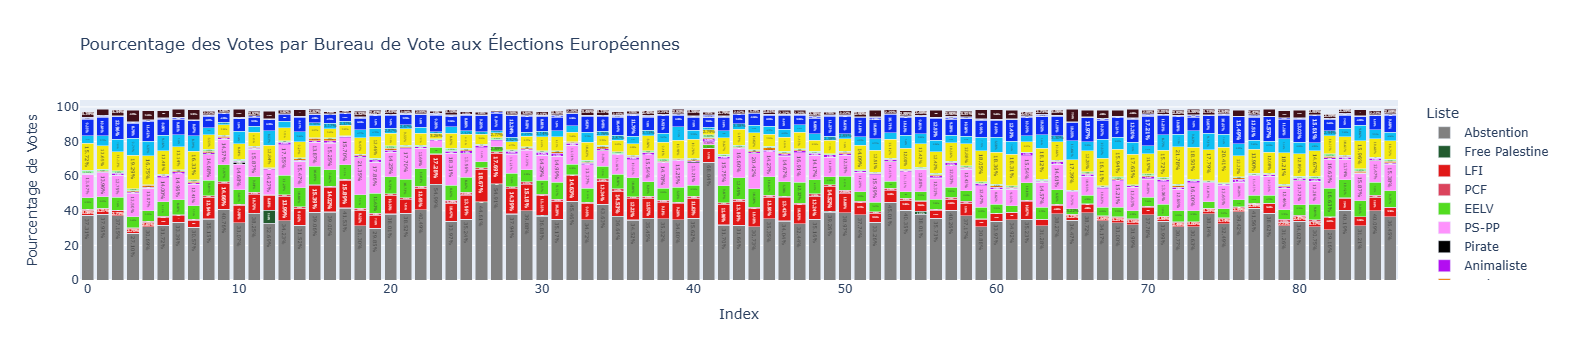

In [831]:
#Représentation européennes (% par inscrits)
#Reformatage pour graphique empilé 

data = pd.DataFrame({
    'Index': df.index,
    'Commune': df['Libellé commune'],
    'Bureau de vote' : df['id_bv'],
    'Abstention' : df['% Abstention_Euro'],
    'Reconquête' : df['% VINSC_REC_Euro'], #
    'LFI' : df['% VINSC_LFI_Euro'], #
    'RN' : df['% VINSC_RN_Euro'], #
    'EELV' : df['% VINSC_EELV_Euro'], #
    'Free Palestine' : df['% VINSC_PALES_Euro'], #
    'Animaliste' : df['% VINSC_ANIM_Euro'], #
    'Pirate' : df['% VINSC_PIRATE_Euro'], #
    'Renaissance' : df['% VINSC_LREM_Euro'],
    'Equinoxe' : df['% VINSC_EQUI_Euro'], #
    'Asselineau' : df['% VINSC_UPR_Euro'], #
    'LR' : df['% VINSC_LR_Euro'], #
    'Les Patriotes' : df['% VINSC_PHIL_Euro'], #
    'PS-PP' : df['% VINSC_PP_Euro'], #
    'PCF' : df['% VINSC_PCF_Euro'], #
    'Ecologie au centre' : df['% VINSC_ECOC_Euro'] #
})

liste_col = ['Abstention', 'Free Palestine', 'LFI', 'PCF', 'EELV', 'PS-PP', 'Pirate', 'Animaliste', 'Equinoxe', 'Ecologie au centre', 'Renaissance', 'LR', 'RN', 'Asselineau', 'Les Patriotes', 'Reconquête']

df_melted = data.melt(id_vars=['Index', 'Bureau de vote', 'Commune'], value_vars=liste_col, var_name ='Liste', value_name='Score (%)')

couleurs = {
    'Abstention': 'grey',
    'Free Palestine': '#225b2f',
    'LFI': '#e11818',
    'PCF': '#db435c',
    'EELV': '#53dc20',
    'PS-PP': '#fe92fc',
    'Pirate': '#000000',
    'Animaliste': '#b30ef1',
    'Equinoxe': '#f37d00 ',
    'Ecologie au centre': '#99fca5',
    'Renaissance': '#f3e80e',
    'LR': '#0ebff3',
    'RN': '#0e2df3',
    'Asselineau': '#6772ff',
    'Les Patriotes': '#afb5fa',
    'Reconquête': '#411018'
}

# Création du graphique à barres empilées
fig = px.bar(df_melted,
             x='Index',  # Utiliser la colonne Bureau de vote avec accolade
             y='Score (%)',
             color='Liste',
             title='Pourcentage des Votes par Bureau de Vote aux Élections Européennes',
             labels={'Score (%)': 'Pourcentage de Votes'},
             text='Score (%)',
             color_discrete_map=couleurs,  # Appliquez le dictionnaire de couleurs
             hover_data={'Commune': True})  # Affiche le libellé de la commune

# Ajustement des propriétés de texte
fig.update_traces(texttemplate='%{text:.2f}%', textposition='inside')
fig.update_layout(barmode='stack')

#Sauvegarde
fig.write_html("graphiques/euro_interactive.html") #Version interactive
fig.write_image("graphiques/euro_statique.png", width=800, height=600)

# Affichage du graphique
fig.show()

In [832]:
#Représentation 2nd tour législatives (% suffrages exprimés) 

# Visualisation en 3D avec la colonne Couleur
manip = df.copy() 
manip['Vote NFP (%)'] = manip['% VEXP_UG_LegiT2']

fig = px.scatter_3d(
    manip,
    x='% VEXP_LREM_LegiT2',         # Proportion pour Olivier Véran
    y='% VEXP_UG_LegiT2',           # Proportion pour Hugo Prévost
    z='% VEXP_UXD_LegiT2',          # Proportion pour Alexandre Lacroix
    color='Vote NFP (%)',                # Intensité couleur selon la colonne créée
    color_continuous_scale=px.colors.sequential.YlOrRd,  # Dégradé de jaune à rouge
    size='Inscrits_LegiT1',         # Taille des points selon le nombre total d'inscrits
    hover_name='Libellé commune',   # Nom de la commune
    title="Représentation des votes (% exprimés) par bureau de vote"
)

# Ajouter un hovertemplate pour personnaliser les info-bulles
fig.update_traces(
    hovertemplate=(
        'Commune: %{hovertext}<br>' +
        'Olivier Véran: %{x:.2f}<br>' +
        'Hugo Prévost: %{y:.2f}<br>' +
        'Alexandre Lacroix: %{z:.2f}<br>' +
        'Inscrits: %{customdata[0]}<br>'
    ),
    customdata=df[['Inscrits_LegiT1']].values,  # Ajouter les inscrits comme données personnalisées
)


# Personnalisation des axes
fig.update_layout(scene=dict(
    xaxis_title="LREM (%)",
    yaxis_title="NFP (%)",
    zaxis_title="UXD (%)"
))

# Supprimer la barre de dégradé (color bar)
fig.write_html("graphiques/votes_BV_LEGIT2.html")

# Afficher le graphique 
fig.show()

### Report de voix entre législatives et européennes

On va estimer une matrice de transfert des voix entre les européennes et les législatives pour comprendre comment le voix ont pu se reporter.

In [833]:
def ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6):
    """
    Méthode itérative pour estimer la matrice de transfert
    """
     # Conversion en matrices NumPy si ce sont des DataFrames Pandas
    n_bureaux, n_cand_t1 = X.shape
    n_cand_t2 = y.shape[1]
    
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.DataFrame) else y
    
    # 1. Initialisation de la matrice de transfert
    T = np.ones((n_cand_t1, n_cand_t2)) / n_cand_t2
    
    for iter in range(max_iter):
        T_old = T.copy()
        
        # 2. Contrainte sur Y (colonnes)
        Y_hat = X @ T  # votes prédits
        col_adjust = y / Y_hat
        T = T * (X.T @ col_adjust / X.sum(axis=0).reshape(-1, 1))
        
        # 3. Normalisation (somme des lignes = 1)
        row_sums = T.sum(axis=1, keepdims=True)
        T = T / row_sums
        
        # Convergence
        if np.max(np.abs(T - T_old)) < tol:
            break
            
    return T

def plot_transfer_matrix(T):
    """Affiche la matrice de transfert uniquement avec des couleurs rouges, des labels personnalisés, et les chiffres en pourcentage"""
    plt.figure(figsize=(10, 8))
    
    # Définir les labels pour les lignes (candidats du premier tour) et colonnes (candidats du second tour)
    labels_X = ['Abstention',  'FREE PALES', 'LFI', 'PCF', 'EELV', 'PS-PP', 'PIRATE', 'EQUINOXE', 'ANIMALISTE', 'ECOLOGIE AU CENTRE', 
               'LREM', 'LR', 'RN', 'UPR', 'LES PATRIOTES', 'REC']
    labels_y = ['Abstention', 'LO', 'UG', 'LREM', 'LR', 'UXD']
    
      # Préparer les annotations manuellement pour ajouter le symbole %
    annot = np.array([["{:.2f}%".format(val * 100) for val in row] for row in T])

    # Affichage de la heatmap avec les chiffres, couleurs rouges et étiquettes personnalisées
    sns.heatmap(T * 100, annot=annot, fmt='', cmap="Reds", xticklabels=labels_y, yticklabels=labels_X)
    
    # Configuration des titres et labels d'axes
    plt.title('Matrice de transfert (en %)', fontsize=14)
    plt.xlabel("Candidats Tour 1 (Législatives)", fontsize=12)
    plt.ylabel("Candidats Tour 1 (Européennes)", fontsize=12)

    plt.savefig('graphiques/transfert_381_eurolegiT1.jpg')
    
    plt.show()

/tmp/ipykernel_10038/250822973.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10038/250822973.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



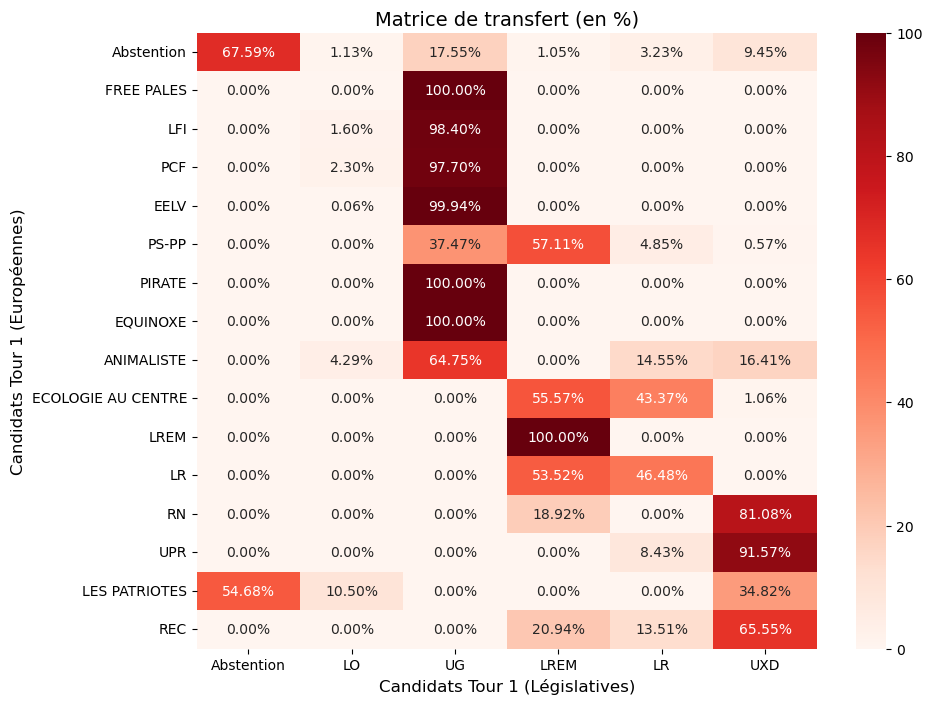

In [834]:
X = df[['% Abstention_Euro',  '% VINSC_PALES_Euro', '% VINSC_LFI_Euro', '% VINSC_PCF_Euro', '% VINSC_EELV_Euro',  '% VINSC_PP_Euro',  
        '% VINSC_PIRATE_Euro', '% VINSC_EQUI_Euro', '% VINSC_ANIM_Euro', '% VINSC_ECOC_Euro', '% VINSC_LREM_Euro',  '% VINSC_LR_Euro', 
        '% VINSC_RN_Euro',  '% VINSC_UPR_Euro', '% VINSC_PHIL_Euro', '% VINSC_REC_Euro']]
y = df[['% Abstentions_LegiT1','% VINSC_LO_LegiT1', '% VINSC_UG_LegiT1', '% VINSC_LREM_LegiT1','% VINSC_LR_LegiT1', '% VINSC_UXD_LegiT1']]

for col in X.columns:
    X[col] = X[col]/100

for col in y.columns:
    y[col] = y[col]/100


T = ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6)

plot_transfer_matrix(T)

### Effets du regain de participation 

Avons-nous observé un gain de participation dans la circonscription entre les élections ? Nous allons effectuer les démarches suivantes :
- Analyse du différentiel de participation entre européennes / Législatives premier tour puis européennes / Législatives second tour
- Observer la corrélation entre les votes pour les listes européennes et le différentiel d'abstention

In [835]:
df2 = df.copy()

df2['% diff_participation_EUROT1'] = df2['% Votants_LegiT1'] - df2['% Votants_Euro']
df2['% diff_participation_EUROT2'] = df2['% Votants_LegiT2'] - df2['% Votants_Euro']
df2['% diff_participation_E2E'] = df2['% diff_participation_EUROT1'] - df2['% diff_participation_EUROT2'] #Diff entre deux tours

In [836]:
df2[['% diff_participation_EUROT1', '% diff_participation_EUROT1','% diff_participation_E2E']].describe()

,% diff_participation_EUROT1,% diff_participation_EUROT1,% diff_participation_E2E
count,87.00000,87.00000,87.000000
mean,11.98000,11.98000,0.183103
std,2.42199,2.42199,1.313223
min,-2.01000,-2.01000,-2.620000
25%,10.87500,10.87500,-0.700000
50%,12.03000,12.03000,0.240000
75%,13.44500,13.44500,1.000000
max,16.38000,16.38000,3.920000


/tmp/ipykernel_10038/525668472.py:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



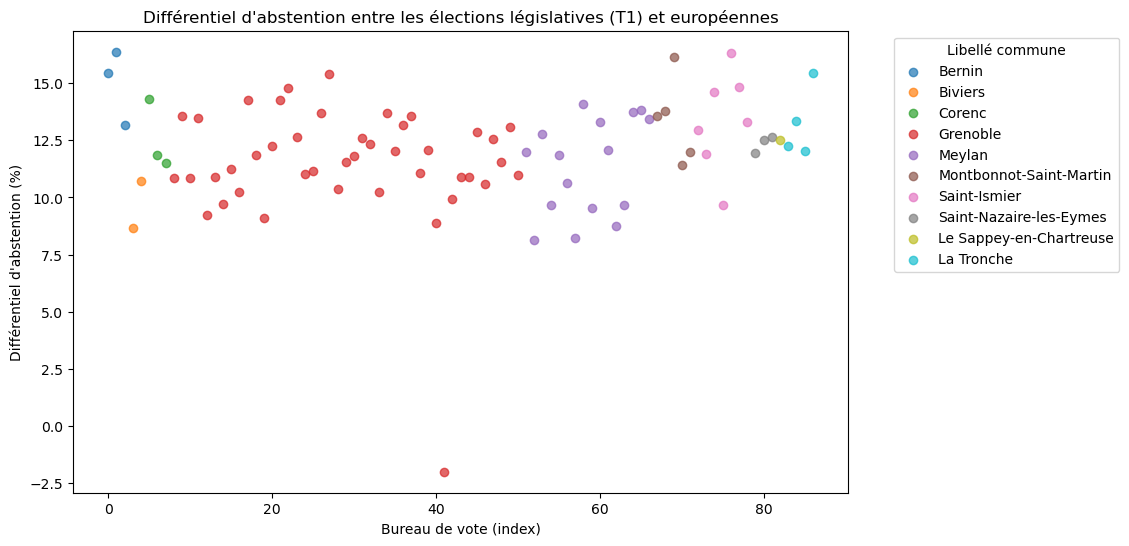

/tmp/ipykernel_10038/525668472.py:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



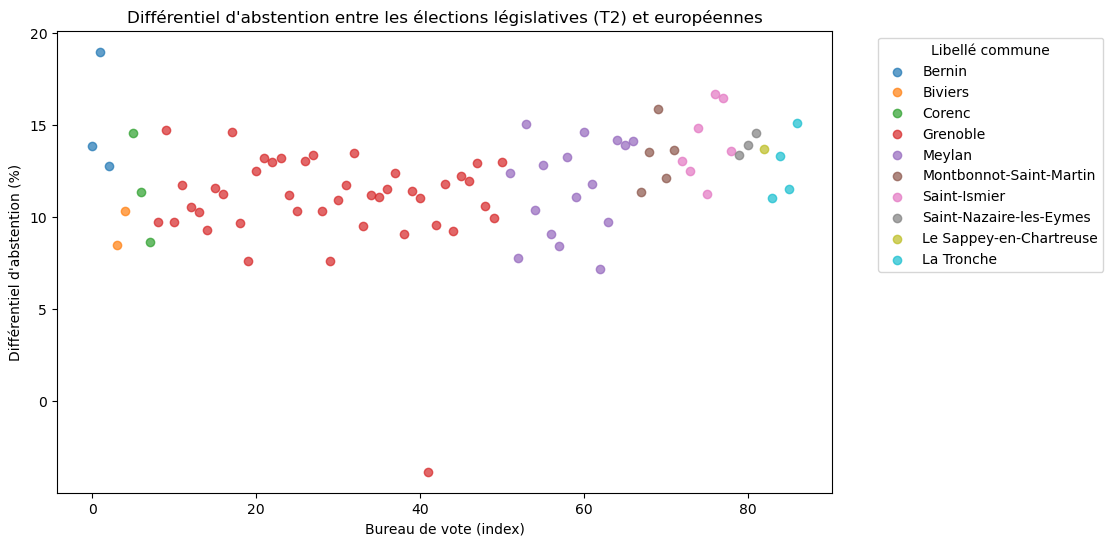

In [837]:
x_values = np.arange(0, len(df2), 1)
# Créer le nuage de points
# Créer un colormap
unique_labels = df2['Libellé commune'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Choisir un colormap avec suffisamment de couleurs

# Mapper les couleurs aux labels
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

# Tracer les points
plt.figure(figsize=(10, 6))
for label in unique_labels:
    plt.scatter(x_values[df2['Libellé commune'] == label],
                df2['% diff_participation_EUROT1'][df2['Libellé commune'] == label],
                alpha=0.7,
                color=color_map[label],
                label=label)

plt.xlabel("Bureau de vote (index)")
plt.ylabel("Différentiel d'abstention (%)")
plt.title("Différentiel d'abstention entre les élections législatives (T1) et européennes")
plt.legend(title="Libellé commune", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('graphiques/diff_euroT1.jpg')
plt.show()

plt.close() 

unique_labels = df2['Libellé commune'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Choisir un colormap avec suffisamment de couleurs

# Mapper les couleurs aux labels
color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

# Tracer les points
plt.figure(figsize=(10, 6))
for label in unique_labels:
    plt.scatter(x_values[df2['Libellé commune'] == label],
                df2['% diff_participation_EUROT2'][df2['Libellé commune'] == label],
                alpha=0.7,
                color=color_map[label],
                label=label)

plt.xlabel("Bureau de vote (index)")
plt.ylabel("Différentiel d'abstention (%)")
plt.title("Différentiel d'abstention entre les élections législatives (T2) et européennes")
plt.legend(title="Libellé commune", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('graphiques/diff_euroT2.jpg')
plt.show()

La participation a augmenté de plus de 10% en moyenne, seul le bureau de vote avec un nombre faible de votant (qui est un bureau de vote assez dfiférent des autres) enregistre une baisse. Le regain de participation ne semble pas énormément varier entre les villes.

Entre les deux tours, la participation varie peu.

En dehors de ce bureau aberrant, les différences d'abstention paraissent normalement distribués, on va donc continuer avec les régressions linéaires pondérées. Nous allons comparer la participation au premier tour et les résultats de différentes listes aux européennes

In [838]:
X = df2[['% VINSC_LFI_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_LFI_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:     % diff_participation_EUROT1   R-squared:                       0.008
Model:                                     WLS   Adj. R-squared:                 -0.004
Method:                          Least Squares   F-statistic:                    0.6982
Date:                         Wed, 06 Nov 2024   Prob (F-statistic):              0.406
Time:                                 11:45:29   Log-Likelihood:                -183.21
No. Observations:                           87   AIC:                             370.4
Df Residuals:                               85   BIC:                             375.4
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [839]:
X = df2[['% VINSC_PCF_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_PCF_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:     % diff_participation_EUROT1   R-squared:                       0.027
Model:                                     WLS   Adj. R-squared:                  0.016
Method:                          Least Squares   F-statistic:                     2.386
Date:                         Wed, 06 Nov 2024   Prob (F-statistic):              0.126
Time:                                 11:45:29   Log-Likelihood:                -182.36
No. Observations:                           87   AIC:                             368.7
Df Residuals:                               85   BIC:                             373.7
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [840]:
X = df2[['% VINSC_EELV_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_EELV_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:     % diff_participation_EUROT1   R-squared:                       0.003
Model:                                     WLS   Adj. R-squared:                 -0.009
Method:                          Least Squares   F-statistic:                    0.2701
Date:                         Wed, 06 Nov 2024   Prob (F-statistic):              0.605
Time:                                 11:45:30   Log-Likelihood:                -183.43
No. Observations:                           87   AIC:                             370.9
Df Residuals:                               85   BIC:                             375.8
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [841]:
X = df2[['% VINSC_PP_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_PP_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:     % diff_participation_EUROT1   R-squared:                       0.029
Model:                                     WLS   Adj. R-squared:                  0.017
Method:                          Least Squares   F-statistic:                     2.504
Date:                         Wed, 06 Nov 2024   Prob (F-statistic):              0.117
Time:                                 11:45:30   Log-Likelihood:                -182.30
No. Observations:                           87   AIC:                             368.6
Df Residuals:                               85   BIC:                             373.5
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [842]:
X = df2[['% VINSC_LREM_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_LREM_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:     % diff_participation_EUROT1   R-squared:                       0.001
Model:                                     WLS   Adj. R-squared:                 -0.010
Method:                          Least Squares   F-statistic:                    0.1274
Date:                         Wed, 06 Nov 2024   Prob (F-statistic):              0.722
Time:                                 11:45:30   Log-Likelihood:                -183.50
No. Observations:                           87   AIC:                             371.0
Df Residuals:                               85   BIC:                             375.9
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [843]:
X = df2[['% VINSC_LR_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_LR_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:     % diff_participation_EUROT1   R-squared:                       0.002
Model:                                     WLS   Adj. R-squared:                 -0.010
Method:                          Least Squares   F-statistic:                    0.1796
Date:                         Wed, 06 Nov 2024   Prob (F-statistic):              0.673
Time:                                 11:45:30   Log-Likelihood:                -183.48
No. Observations:                           87   AIC:                             371.0
Df Residuals:                               85   BIC:                             375.9
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [844]:
X = df2[['% VINSC_RN_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_RN_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:     % diff_participation_EUROT1   R-squared:                       0.029
Model:                                     WLS   Adj. R-squared:                  0.017
Method:                          Least Squares   F-statistic:                     2.516
Date:                         Wed, 06 Nov 2024   Prob (F-statistic):              0.116
Time:                                 11:45:31   Log-Likelihood:                -182.30
No. Observations:                           87   AIC:                             368.6
Df Residuals:                               85   BIC:                             373.5
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [845]:
X = df2[['% VINSC_REC_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_REC_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:     % diff_participation_EUROT1   R-squared:                       0.003
Model:                                     WLS   Adj. R-squared:                 -0.009
Method:                          Least Squares   F-statistic:                    0.2205
Date:                         Wed, 06 Nov 2024   Prob (F-statistic):              0.640
Time:                                 11:45:31   Log-Likelihood:                -183.46
No. Observations:                           87   AIC:                             370.9
Df Residuals:                               85   BIC:                             375.8
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

Seul le pourcentage de voix exprimé pour le RN aux européennes est positivement corrélé avec le différentiel de participation au premier tour : 1% de plus donné à la liste de Bardella est corrélé au gain de 0.09% de participation entre les 2 élections. Vérifions si cela reste vrai en comparant au second tour.

In [846]:
X = df2[['% VINSC_LFI_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_LFI_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VINSC_PCF_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_PCF_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VINSC_EELV_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_EELV_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VINSC_PP_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_PP_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VINSC_LREM_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_LREM_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VINSC_LR_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_LR_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VINSC_RN_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_RN_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VINSC_REC_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df2[['% VEXP_REC_Euro']]
X = sm.add_constant(X) 

Y = df2['% diff_participation_EUROT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:     % diff_participation_EUROT2   R-squared:                       0.048
Model:                                     WLS   Adj. R-squared:                  0.037
Method:                          Least Squares   F-statistic:                     4.281
Date:                         Wed, 06 Nov 2024   Prob (F-statistic):             0.0416
Time:                                 11:45:31   Log-Likelihood:                -195.66
No. Observations:                           87   AIC:                             395.3
Df Residuals:                               85   BIC:                             400.3
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

Au second tour, on observe davantage d'effet du parti voté aux européennes sur l'abstention. Pour les électeurs de gauche, on observe des corrélations négatives entre la part de vote LFI parmi les inscrits et le différentiel d'abstention, ainsi que pour le PCF (mais cela s'exprime en + dans la part des suffrages exprimés). 

La part de suffrage exprimé pour la liste LREM est positivement corrélé à la différence de participation. 
La part de vote RN parmi les inscrits ainsi que les exprimés est positivement corrélé avec la différence de participation. 

Le nombre d'inscrits sera supposé égal aux nombre d'inscrits au second tour des élections législatives 2024.

Cela semble donc suggérer que les électeurs RN et LREM se sont possiblement davantage mobilisés au second tour des législatives qu'aux européennes, tandis qu'on observe l'effet inverse chez les électeurs LFI-PCF. 

__Au premier tour, la mobilisation ne semble pas corrélée à la préférence partisane (à part légèrement pour le RN). En revanche, au second tour, davantage de personnes de droite se sont mobilisées, et moins de personnes de gauche. Peut-être que le candidat de gauche ayant été en tête, les électeurs de gauche se sont moins déplacés et ceux de droite daantage. Il est donc crucial de se concentrer sur la campagne d'entre deux tours pour le NFP.__ 

## Projection des résultats de la législative partielle de janvier 2025

Nous allons donc chercher à prédire les résultats possibles pour les élections à venir. Cependant, il faudra s'atteler à plusieurs difficultés 

- La baisse de participation : en contexte de législatives partielles, la participation est souvent plus basse, on ne peut donc pas se baser sur la participation aux élections de l'été 2024 pour prédire le résultat.
- Inconnue sur le candidat macroniste : Véran ou un autre ? En effet, nous pouvons supposer que la personne de Véran a un effet au-delà de l'étiquette (apprécié comme baron local/respectabilité du passé de ministre, mais image dégradée par la gestion COVID + polémique sur la chirurgie esthétique). Nous allons donc devoir envisager deux scénario : Véran VS inconnu macroniste
- Présence d'un ou deux candidats à gauche (Lyes Louffok, Amandine Germain) : nous considérerons le cas d'une candidature unique de Lyes Louffok, ou le cas de deux candidatures

L'objectif ici est de se concentrer sur les 3 blocs (Gauche, Bourgeois (macron / Centre-Droit), Extrême Droite). Nous ne nous psoerons pas la question d'une candidature LR ici. Egalement, nous supposons que le nom du candidat RN n'a pas d'importance car la force du RN se situe dans son étiquette et non dans ses candidats. 

Nous supposerons également une candidature LR (Nathalie Béranger) et une candidature Lutte Ouvrière dans les prévisions du premier tour. La baisse de participation affectera également tous les votes au sein d'un même bureau (vu qu'aucun parti n'a semblé considérablement bénéficié du gain de participation aux législatives lros du 1er tour)

Nous procéderons à des simulations pour obtenir des résultats variables

### Prévision de l'abstention

Il est difficile de prévoir la participation à une législative partielle. En effet, en considérant les 5 élections législatives partielles ayant eu lieu dans des circonscriptions en France depuis 2022 (on ne compte pas celles des Fr. de l'étranger), on s'aperçoit que la participation a baissé de 15% à 35% entre la partielle et la législative de 2022. En terme de participation, la 1ère circonscription de L'Isère avait un taux d'abstention d'environ 43% en 2022, ce qui correspond aux chiffres observées dans la 2ème circonscription des Yvelines ou de la première circonscription de l'Ariège. Cependant, l'abstention a été de 73% pour le premier tour et 77% pour le second dans les Yvelines tandis qu'on obtenait plutot des taux d'abstention de 60% et 62% en Ariège. 

Nous ferions donc varier aléatoirement l'abstention par bureau de vote de 20% à la baisse en moyenne (avec des écarts type de 3%). 
Nous testerons également un scénario punitif où la participation baisserait de 15% en moyenne hors Grenoble et de 25% à Grenoble (considérer un scénario plutôt pessimiste puisque la gauche fait ses scores principalement à Grenoble dans la circonscription). Cela repose sur l'hypothèse que la démobilisation serait plus forte dans les quartiers de Teisseire et de l'Abbaye

### Effet Véran

Véran a-t-il un effet mobilisateur ou repoussoir auprès de l'électorat grenoblois de centre-droit ? Nous avons déjà établi que les électeurs de PS-PP semblaient préférer Prevost à Véran. Mais qu'en est-il des électeurs LREM ? Nous allons comparer avec les résultats des européennes : notre intuition est qu'un électeur de la liste de Valérie Hayer choisissait + le mouvement Renaissance qu'une personne en particulier (ce qui parait raisonnable). Nous allons donc chercher à mesurer si Véran a attiré plus de voix ou éloigné davantage d'électeurs. Nous avons contrôlé par l'abstention.

In [853]:
X = df[['% VEXP_LREM_Euro', '% Abstention_Euro']]
X = sm.add_constant(X) 

Y = df2['% VEXP_LREM_LegiT1']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

X = df[['% VEXP_LREM_Euro', '% Abstention_Euro']]
X = sm.add_constant(X) 

Y = df2['% VEXP_LREM_LegiT2']

weights = df2['Inscrits_LegiT1']

model = sm.WLS(Y, X, weights=weights).fit() 
print(model.summary())

                            WLS Regression Results                            
Dep. Variable:     % VEXP_LREM_LegiT1   R-squared:                       0.916
Model:                            WLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     456.5
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           7.48e-46
Time:                        12:12:52   Log-Likelihood:                -217.09
No. Observations:                  87   AIC:                             440.2
Df Residuals:                      84   BIC:                             447.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                16.5450      3.15

1% de vote en plus pour la liste RENAISSANCE est corrélé au gain de 1,47% de voix pour Olivier Véran. Il est donc difficile de savoir si cet écart est lié au fait que Véran attire davantage d'électeurs ou si pour les européennes, les électeurs profitent d'avoir eu un choix plus large. 

### Prévisions de premier tour si configuration identique à l'été 2024

Nous allons commencer par le scénario le plus proche de la législative de 2024 : un candidat LFI-NFP contre Olivier Véran. les scores varieront aléatoirement par rapport aux scores de 2024 (en ayant des différences plus ou moins importantes : plus les candidats ont eu de voix, plus leur résultat est supposé variable). 

NOTE : Le total ne fait pas 100% à cause des variations aléatoires


In [892]:
def var_participation(value, code_commune): #Fonction pour pénalisation égale par l'abstention entre les communes
    random_var = np.random.normal(20, 3, 1)[0]
    part = value-random_var 
    part = np.clip(part, 0,100) #Le nombre doit être compris entre 0 et 100
    return part

def var_participation_penalite(value, code_commune): 
    if code_commune == 38185:  # Code pour Grenoble
        random_var = np.random.normal(25, 3, 1)[0]
        part = value - random_var 
        part = np.clip(part, 0, 100)  # Clip entre 0 et 100 pour Grenoble
    else:
        random_var = np.random.normal(15, 3, 1)[0]
        part = value - random_var 
        part = np.clip(part, 0, 100)  # Clip entre 0 et 80 pour les autres communes
    return part

def report_aleatoire_voix(df_results):
    # Créer une variation aléatoire avec une distribution normale
    inscrits = df_results['Inscrits'].sum()
    df_results['var_LREM'] = abs(np.random.normal(0, 0.2, size=len(df))) #5% de variation aléatoire
    df_results['var_LR'] = abs(np.random.normal(0, 0.05, size=len(df))) 
    df_results['var_UG'] = abs(np.random.normal(0, 0.2, size=len(df)))
    df_results['var_LO'] = abs(np.random.normal(0, 0.007, size=len(df)))
    df_results['var_UXD'] = abs(np.random.normal(0, 0.1, size=len(df)))

    df_report = pd.DataFrame( {'P_LREM': ['A', 0.4, 0.25, 0, 0.35], 'P_LR' : [0.45, 'A', 0.15, 0, 0.4], 'P_UG' : [0.7, 0.1, 'A', 0.05, 0.15],  
    'P_LO' : [0.05, 0.05, 0.8, 'A', 0.1], 'P_UXD':[0.3, 0.55, 0.1, 0.05, 'A']}, 
    index = ['G_LREM', 'G_LR', 'G_UG', 'G_LO', 'G_UXD'] 
    )

    df_report.reset_index(drop=True, inplace=True)
    df_report.columns = range(df_report.shape[1])

    #Electeurs qui ne changent pas d'avis entre les deux législatives
    df_results['Voix_LREM'] = (df['% VEXP_LREM_LegiT1']/100 * df_results['Exprimés']) 
    df_results['Voix_LR'] = (df['% VEXP_LR_LegiT1']/100 * df_results['Exprimés'])  
    df_results['Voix_UG'] = (df['% VEXP_UG_LegiT1']/100 * df_results['Exprimés']) 
    df_results['Voix_LO'] = (df['% VEXP_LO_LegiT1']/100 * df_results['Exprimés']) 
    df_results['Voix_UXD'] = (df['% VEXP_UXD_LegiT1']/100 * df_results['Exprimés'])  

    df_results2 = df_results.copy()

    df_results['Voix_LREM'] = (df['% VEXP_LREM_LegiT1']/100 * df_results['Exprimés']) * (1- df_results['var_LREM'])
    df_results['Voix_LR'] = (df['% VEXP_LR_LegiT1']/100 * df_results['Exprimés'])  * (1- df_results['var_LR'])
    df_results['Voix_UG'] = (df['% VEXP_UG_LegiT1']/100 * df_results['Exprimés']) * (1- df_results['var_UG'])
    df_results['Voix_LO'] = (df['% VEXP_LO_LegiT1']/100 * df_results['Exprimés']) * (1- df_results['var_LO'])
    df_results['Voix_UXD'] = (df['% VEXP_UXD_LegiT1']/100 * df_results['Exprimés'])  * (1- df_results['var_UXD'])

    col_list = ['Voix_LREM', 'Voix_LR', 'Voix_UG', 'Voix_LO', 'Voix_UXD']
    var_list = ['var_LREM', 'var_LR', 'var_UG', 'var_LO', 'var_UXD']


    for col, var, i in zip(col_list, var_list, range(5)):
        for col2, j in zip(col_list, range(5)):
            if col != col2:
                df_results[col2] += df_results2[col]*(df_report.loc[j, i]*df_results[var])

    df_results = df_results.drop(columns=var_list)
    
    return df_results 
    
# Fonction de simulation
def simu_veran_lfi_T1(var_function_abs): #Fonction augmentant l'abstention à Grenoble 
    df_results = pd.DataFrame()
    df_results['Inscrits'] = df['Inscrits_LegiT2'] #On fixe le nombre d'inscrits
    df['% Exprimés_LegiT1'] = (df['Exprimés_LegiT1']/df['Inscrits_LegiT1']) * 100
    df_results['% Exprimés'] = df.apply(
        lambda row: var_function_abs(row['% Exprimés_LegiT1'], row['Code commune']), axis=1 #On estime le pourcent de votant aléatoirement
    )
    df_results['Exprimés'] = df_results['% Exprimés']/100 * df_results['Inscrits']
    df_results['Exprimés'] = df_results['Exprimés'].apply(lambda x: round(x)) #On arront à l'entier le nombre de votants 

    df_results = report_aleatoire_voix(df_results)

    #Arrondis
    for col in ['Voix_LREM', 'Voix_LR', 'Voix_UG', 'Voix_LO', 'Voix_UXD']:
        df_results[col] = df_results[col].apply(lambda x: round(x))

    #Obtention des pourcentages par inscrits / suffrages exprimés
    df_results['% VEXP_LREM'] = df_results['Voix_LREM']/df_results['Exprimés']
    df_results['% VEXP_LR'] = df_results['Voix_LR']/df_results['Exprimés']
    df_results['% VEXP_LO'] = df_results['Voix_LO']/df_results['Exprimés']
    df_results['% VEXP_UG'] = df_results['Voix_UG']/df_results['Exprimés']
    df_results['% VEXP_UXD'] = df_results['Voix_UXD']/df_results['Exprimés']
    
    df_results['% VINSC_LREM'] = df_results['Voix_LREM']/df_results['Inscrits']
    df_results['% VINSC_LR'] = df_results['Voix_LR']/df_results['Inscrits']
    df_results['% VINSC_LO'] = df_results['Voix_LO']/df_results['Inscrits']
    df_results['% VINSC_UG'] = df_results['Voix_UG']/df_results['Inscrits']
    df_results['% VINSC_UXD'] = df_results['Voix_UXD']/df_results['Inscrits']

    return df_results

#Fonction pour résumer les résultats
def sum_ressimu(simu, var_function_abs):
    #Récupération des résultats
    df_results=simu(var_function_abs)

    #Calcul des totaux
    total_exp = df_results['Exprimés'].sum()
    total_inscrits = df_results['Inscrits'].sum()
    total_voixLREM = df_results['Voix_LREM'].sum()
    total_voixLR = df_results['Voix_LR'].sum()
    total_voixLO = df_results['Voix_LO'].sum()
    total_voixUXD = df_results['Voix_UXD'].sum()
    total_voixUG = df_results['Voix_UG'].sum()

    #Calcul des pourcentages 
    Abs = 1 - (total_exp/total_inscrits) 
    
    inscr_LREM = total_voixLREM/total_inscrits *100
    inscr_LR = total_voixLR/total_inscrits *100
    inscr_LO = total_voixLO/total_inscrits *100
    inscr_UXD = total_voixUXD/total_inscrits *100
    inscr_UG = total_voixUG/total_inscrits *100

    exp_LREM = total_voixLREM/total_exp *100
    exp_LR = total_voixLR/total_exp *100
    exp_LO = total_voixLO/total_exp *100
    exp_UXD = total_voixUXD/total_exp *100
    exp_UG = total_voixUG/total_exp *100

    df_total = pd.DataFrame({
        'Total_Voix': [total_voixLREM, total_voixLR, total_voixLO, total_voixUXD, total_voixUG],
        'Pourcentage_Inscrits': [inscr_LREM, inscr_LR, inscr_LO, inscr_UXD, inscr_UG],
        'Pourcentage_Exp': [exp_LREM, exp_LR, exp_LO, exp_UXD, exp_UG]
    }, index=['LREM', 'LR', 'LO', 'UXD', 'UG'])

    df_total.loc['Abstention'] = ['x', Abs, 'x'] 

    return df_total
    

In [894]:
sum_ressimu(simu_veran_lfi_T1, var_participation)

,Total_Voix,Pourcentage_Inscrits,Pourcentage_Exp
LREM,15365,18.303433,33.291444
LR,4737,5.642913,10.263688
LO,567,0.675434,1.228523
UXD,9219,10.982060,19.974866
UG,16269,19.380316,35.250146
Abstention,x,0.450206,x


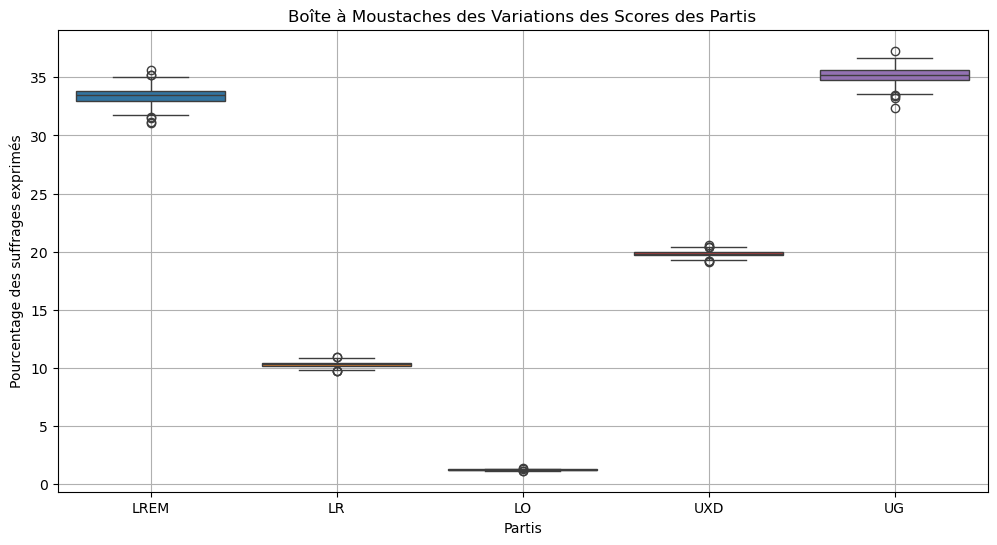

In [855]:
def run_multiple_simulations(n_simulations, simu, var_function_abs):
    results = {
        'LREM': [],
        'LR': [],
        'LO': [],
        'UXD': [],
        'UG': [],
    }

    for _ in range(n_simulations):
        df_total = sum_ressimu(simu, var_function_abs)
        
        # Collecte des scores pour chaque parti
        results['LREM'].append(df_total.loc['LREM', 'Pourcentage_Exp'])
        results['LR'].append(df_total.loc['LR', 'Pourcentage_Exp'])
        results['LO'].append(df_total.loc['LO', 'Pourcentage_Exp'])
        results['UXD'].append(df_total.loc['UXD', 'Pourcentage_Exp'])
        results['UG'].append(df_total.loc['UG', 'Pourcentage_Exp'])

    return pd.DataFrame(results)

# Exécuter plusieurs simulations
n_simulations = 1000  # Nombre de simulations
df_results = run_multiple_simulations(n_simulations, simu_veran_lfi_T1, var_participation)

# Création de la boîte à moustaches
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results)
plt.title('Boîte à Moustaches des Variations des Scores des Partis')
plt.xlabel('Partis')
plt.ylabel('Pourcentage des suffrages exprimés')
plt.grid()
plt.show()

Les résultats sont proches de juin : c'est logique puisqu'on a supposé que l'abstention touchait également tous les bureaux de vote. Voyons ce qui se passe si Grenoble s'abstient davantage 

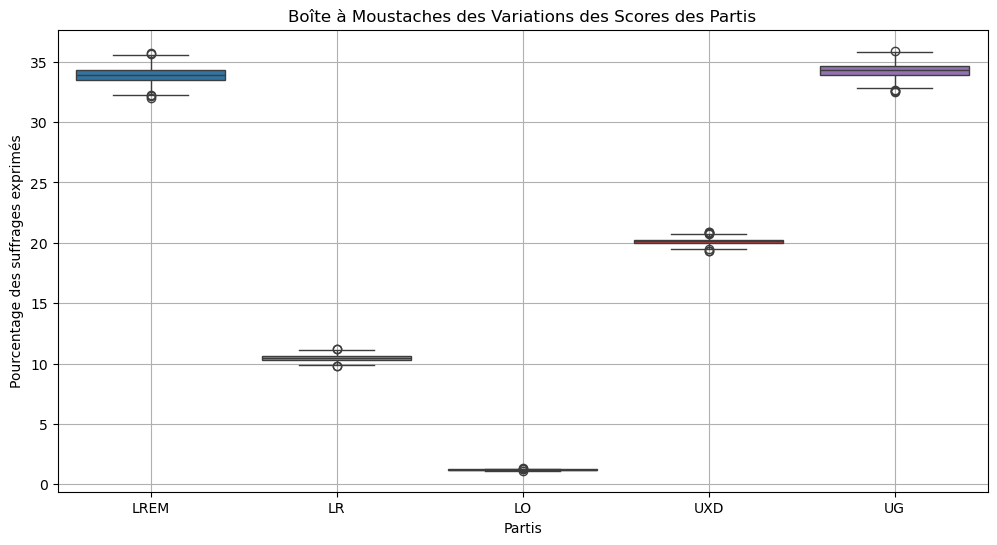

In [856]:
n_simulations = 1000  # Nombre de simulations
df_results = run_multiple_simulations(n_simulations, simu_veran_lfi_T1, var_participation_penalite)

# Création de la boîte à moustaches
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results)
plt.title('Boîte à Moustaches des Variations des Scores des Partis')
plt.xlabel('Partis')
plt.ylabel('Pourcentage des suffrages exprimés')
plt.grid()
plt.show()

## Prévision second tour

Le score du NFP baisse un peu et celui de Véran augmente un peu en pénalisant Grenoble, ce qui est attendu. Cependant, à quelle fréquence obtient-on des triangulaires dans cette circonscription ? 

In [857]:
def frequence_triangulaire(n_simulations, simu, var_function_abs):
    count_triang = 0
    for i in range(n_simulations):
        df_total = sum_ressimu(simu, var_function_abs)
        df_total['Pourcentage_Inscrits'] = df_total['Pourcentage_Inscrits'].astype(float)
        if df_total.loc['UXD', 'Pourcentage_Inscrits'] >= 12.5:
            count_triang=count_triang+1
    freq = count_triang/n_simulations
    return freq

    

In [858]:
frequence_triangulaire(1000, simu_veran_lfi_T1, var_participation)

0.0

In [859]:
frequence_triangulaire(1000, simu_veran_lfi_T1, var_participation_penalite)

0.0

La triangulaire est un scénario extrêmement improbable si notre modèle est bon. La question sera alors les reports de voix au second tour. POur ce faire, nous nous baserons sur les reports de l'élection législative de 2022 pour comprendre ce qui pourrait se jouer. 

Cela va donc nécessiter de l'analyse de données

In [860]:
#Récupération des données de la législative 2022
legit122 = pd.read_excel('data/Legi22T1.xlsx')
legit222 = pd.read_excel('data/Legi22T2.xlsx')

In [861]:
legit122['Code du département'] = legit122['Code du département'].astype(str)
legit12238 = legit122[legit122['Code du département'] == '38']

legit12238['Code de la circonscription'] = legit12238['Code de la circonscription'].astype(str)
legit122_38C1 = legit12238[legit12238['Code de la circonscription'] == '1']

legit222['Code du département'] = legit222['Code du département'].astype(str)
legit22238 = legit222[legit222['Code du département'] == '38']

legit22238['Code de la circonscription'] = legit22238['Code de la circonscription'].astype(str)
legit222_38C1 = legit22238[legit22238['Code de la circonscription'] == '1']

/tmp/ipykernel_10038/2102877869.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10038/2102877869.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [862]:
legit122_38C1 = legit122_38C1.dropna(how='all', inplace=False, axis=1)
legit122_38C1

,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92
24500,38,Isère,1,1ère circonscription,39,Bernin,0001,942,424,45.01,...,1.38,2.58,3.0,F,MEYRIEUX,Aurore,RN,42.0,4.46,8.33
24501,38,Isère,1,1ère circonscription,39,Bernin,0002,956,402,42.05,...,3.77,6.56,3.0,F,MEYRIEUX,Aurore,RN,61.0,6.38,11.11
24502,38,Isère,1,1ère circonscription,39,Bernin,0003,958,428,44.68,...,3.65,6.67,3.0,F,MEYRIEUX,Aurore,RN,43.0,4.49,8.19
24509,38,Isère,1,1ère circonscription,45,Biviers,0001,1023,326,31.87,...,5.57,8.30,3.0,F,MEYRIEUX,Aurore,RN,33.0,3.23,4.80
24510,38,Isère,1,1ère circonscription,45,Biviers,0002,984,344,34.96,...,5.49,8.50,3.0,F,MEYRIEUX,Aurore,RN,47.0,4.78,7.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25299,38,Isère,1,1ère circonscription,471,Le Sappey-en-Chartreuse,0001,971,335,34.50,...,1.54,2.40,3.0,F,MEYRIEUX,Aurore,RN,37.0,3.81,5.91
25379,38,Isère,1,1ère circonscription,516,La Tronche,0001,1058,467,44.14,...,1.80,3.25,3.0,F,MEYRIEUX,Aurore,RN,49.0,4.63,8.39
25380,38,Isère,1,1ère circonscription,516,La Tronche,0002,1058,373,35.26,...,2.93,4.57,3.0,F,MEYRIEUX,Aurore,RN,26.0,2.46,3.83
25381,38,Isère,1,1ère circonscription,516,La Tronche,0003,1055,488,46.26,...,2.94,5.54,3.0,F,MEYRIEUX,Aurore,RN,39.0,3.70,6.96


In [863]:
legit122_exp = pd.DataFrame ({
    'Code commune' : legit122_38C1['Code de la commune'],
    'Code BV' : legit122_38C1['Code du b.vote'],
    'Inscrits_T1' : legit122_38C1['Inscrits'],
    'Abstentions_T1' : legit122_38C1['Abstentions'],
    '% Abs/Ins_T1' : legit122_38C1['% Abs/Ins'],
    'Votants_T1' : legit122_38C1['Votants'],
    '% Votants/Ins_T1' : legit122_38C1['% Vot/Ins'],
    'Blancs_T1' : legit122_38C1['Blancs'],
    '% Blancs/Vot_T1' : legit122_38C1['% Blancs/Vot'],
    'Exprimés_T1' : legit122_38C1['Exprimés'],
    '% Exp/Vot_T1' : legit122_38C1['% Exp/Vot'],
    'Voix_LO_T1' : legit122_38C1['Voix'],
    '% VINS_LO_T1' : legit122_38C1['% Voix/Ins'],
    '% VEXP_LO_T1' : legit122_38C1['% Voix/Exp'],
    'Voix_UG_T1' : legit122_38C1['Unnamed: 34'],
    '% VINS_UG_T1' : legit122_38C1['Unnamed: 35'],
    '% VEXP_UG_T1' : legit122_38C1['Unnamed: 36'],
    'Voix_LREM_T1' : legit122_38C1['Unnamed: 58'],
    '% VINS_LREM_T1' : legit122_38C1['Unnamed: 59'],
    '% VEXP_LREM_T1' : legit122_38C1['Unnamed: 60'],
    'Voix_LR_T1' : legit122_38C1['Unnamed: 66'],
    '% VINS_LR_T1' : legit122_38C1['Unnamed: 67'],
    '% VEXP_LR_T1' : legit122_38C1['Unnamed: 68'],
    'Voix_REC_T1' : legit122_38C1['Unnamed: 82'],
    '% VINS_REC_T1' : legit122_38C1['Unnamed: 83'],
    '% VEXP_REC_T1' : legit122_38C1['Unnamed: 84'],
    'Voix_RN_T1' : legit122_38C1['Unnamed: 90'],
    '% VINS_RN_T1' : legit122_38C1['Unnamed: 91'],
    '% VEXP_RN_T1' : legit122_38C1['Unnamed: 92'],
})

legit122_exp 

,Code commune,Code BV,Inscrits_T1,Abstentions_T1,% Abs/Ins_T1,Votants_T1,% Votants/Ins_T1,Blancs_T1,% Blancs/Vot_T1,Exprimés_T1,...,% VEXP_LREM_T1,Voix_LR_T1,% VINS_LR_T1,% VEXP_LR_T1,Voix_REC_T1,% VINS_REC_T1,% VEXP_REC_T1,Voix_RN_T1,% VINS_RN_T1,% VEXP_RN_T1
24500,39,0001,942,424,45.01,518,54.99,9,1.74,504,...,50.40,36.0,3.82,7.14,13.0,1.38,2.58,42.0,4.46,8.33
24501,39,0002,956,402,42.05,554,57.95,4,0.72,549,...,47.54,33.0,3.45,6.01,36.0,3.77,6.56,61.0,6.38,11.11
24502,39,0003,958,428,44.68,530,55.32,4,0.75,525,...,48.76,33.0,3.44,6.29,35.0,3.65,6.67,43.0,4.49,8.19
24509,45,0001,1023,326,31.87,697,68.13,10,1.43,687,...,55.17,79.0,7.72,11.50,57.0,5.57,8.30,33.0,3.23,4.80
24510,45,0002,984,344,34.96,640,65.04,4,0.63,635,...,51.02,66.0,6.71,10.39,54.0,5.49,8.50,47.0,4.78,7.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25299,471,0001,971,335,34.50,636,65.50,10,1.57,626,...,38.82,18.0,1.85,2.88,15.0,1.54,2.40,37.0,3.81,5.91
25379,516,0001,1058,467,44.14,591,55.86,5,0.85,584,...,42.98,45.0,4.25,7.71,19.0,1.80,3.25,49.0,4.63,8.39
25380,516,0002,1058,373,35.26,685,64.74,5,0.73,678,...,51.33,55.0,5.20,8.11,31.0,2.93,4.57,26.0,2.46,3.83
25381,516,0003,1055,488,46.26,567,53.74,5,0.88,560,...,37.32,26.0,2.46,4.64,31.0,2.94,5.54,39.0,3.70,6.96


In [864]:
legit222_38C1 = legit222_38C1.dropna(how='all', inplace=False, axis=1)
legit222_38C1

,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,% Voix/Ins,% Voix/Exp,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
24500,38,Isère,1,1ère circonscription,39,Bernin,0001,942,417,44.27,...,17.52,32.48,2.0,M,VÉRAN,Olivier,ENS,343.0,36.41,67.52
24501,38,Isère,1,1ère circonscription,39,Bernin,0002,956,422,44.14,...,16.21,31.00,2.0,M,VÉRAN,Olivier,ENS,345.0,36.09,69.00
24502,38,Isère,1,1ère circonscription,39,Bernin,0003,958,443,46.24,...,15.66,30.80,2.0,M,VÉRAN,Olivier,ENS,337.0,35.18,69.20
24509,38,Isère,1,1ère circonscription,45,Biviers,0001,1023,369,36.07,...,14.37,23.90,2.0,M,VÉRAN,Olivier,ENS,468.0,45.75,76.10
24510,38,Isère,1,1ère circonscription,45,Biviers,0002,986,392,39.76,...,15.31,26.40,2.0,M,VÉRAN,Olivier,ENS,421.0,42.70,73.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25299,38,Isère,1,1ère circonscription,471,Le Sappey-en-Chartreuse,0001,971,343,35.32,...,33.26,52.86,2.0,M,VÉRAN,Olivier,ENS,288.0,29.66,47.14
25379,38,Isère,1,1ère circonscription,516,La Tronche,0001,1058,482,45.56,...,22.40,42.55,2.0,M,VÉRAN,Olivier,ENS,320.0,30.25,57.45
25380,38,Isère,1,1ère circonscription,516,La Tronche,0002,1060,356,33.58,...,19.62,30.77,2.0,M,VÉRAN,Olivier,ENS,468.0,44.15,69.23
25381,38,Isère,1,1ère circonscription,516,La Tronche,0003,1055,490,46.45,...,24.83,47.38,2.0,M,VÉRAN,Olivier,ENS,291.0,27.58,52.62


In [865]:
legit222_exp = pd.DataFrame ({
    'Inscrits_T2' : legit222_38C1['Inscrits'],
    'Abstentions_T2' : legit222_38C1['Abstentions'],
    '% Abs/Ins_T2' : legit222_38C1['% Abs/Ins'],
    'Votants_T2' : legit222_38C1['Votants'],
    '% Votants/Ins_T2' : legit222_38C1['% Vot/Ins'],
    'Blancs_T2' : legit222_38C1['Blancs'],
    '% Blancs/Vot_T2' : legit222_38C1['% Blancs/Vot'],
    'Exprimés_T2' : legit222_38C1['Exprimés'],
    '% Exp/Vot_T2' : legit222_38C1['% Exp/Vot'],
    'Voix_UG_T2' : legit222_38C1['Voix'],
    '% VINS_UG_T2' : legit222_38C1['% Voix/Ins'],
    '% VEXP_UG_T2' : legit222_38C1['% Voix/Exp'],
    'Voix_LREM_T2' : legit222_38C1['Unnamed: 34'],
    '% VINS_LREM_T2' : legit222_38C1['Unnamed: 35'],
    '% VEXP_LREM_T2' : legit222_38C1['Unnamed: 36']
})

legit222_exp 

,Inscrits_T2,Abstentions_T2,% Abs/Ins_T2,Votants_T2,% Votants/Ins_T2,Blancs_T2,% Blancs/Vot_T2,Exprimés_T2,% Exp/Vot_T2,Voix_UG_T2,% VINS_UG_T2,% VEXP_UG_T2,Voix_LREM_T2,% VINS_LREM_T2,% VEXP_LREM_T2
24500,942,417,44.27,525,55.73,12,2.29,508,96.76,165,17.52,32.48,343.0,36.41,67.52
24501,956,422,44.14,534,55.86,27,5.06,500,93.63,155,16.21,31.00,345.0,36.09,69.00
24502,958,443,46.24,515,53.76,21,4.08,487,94.56,150,15.66,30.80,337.0,35.18,69.20
24509,1023,369,36.07,654,63.93,32,4.89,615,94.04,147,14.37,23.90,468.0,45.75,76.10
24510,986,392,39.76,594,60.24,20,3.37,572,96.30,151,15.31,26.40,421.0,42.70,73.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25299,971,343,35.32,628,64.68,15,2.39,611,97.29,323,33.26,52.86,288.0,29.66,47.14
25379,1058,482,45.56,576,54.44,15,2.60,557,96.70,237,22.40,42.55,320.0,30.25,57.45
25380,1060,356,33.58,704,66.42,20,2.84,676,96.02,208,19.62,30.77,468.0,44.15,69.23
25381,1055,490,46.45,565,53.55,11,1.95,553,97.88,262,24.83,47.38,291.0,27.58,52.62


In [866]:
legit122_exp.reset_index(inplace=True)
legit222_exp.reset_index(inplace=True)

In [867]:
df_joined = legit122_exp.join(legit222_exp, how='inner', lsuffix='_left', rsuffix='_right')
df_joined.to_excel('data/transformed/legi2022-381.xlsx', index=False)

In [868]:
#Récupération directe des données de 2022
df22 = pd.read_excel('data/transformed/legi2022-381.xlsx')
df22.columns

Index(['index_left', 'Code commune', 'Code BV', 'Inscrits_T1',
       'Abstentions_T1', '% Abs/Ins_T1', 'Votants_T1', '% Votants/Ins_T1',
       'Blancs_T1', '% Blancs/Vot_T1', 'Exprimés_T1', '% Exp/Vot_T1',
       'Voix_LO_T1', '% VINS_LO_T1', '% VEXP_LO_T1', 'Voix_UG_T1',
       '% VINS_UG_T1', '% VEXP_UG_T1', 'Voix_LREM_T1', '% VINS_LREM_T1',
       '% VEXP_LREM_T1', 'Voix_LR_T1', '% VINS_LR_T1', '% VEXP_LR_T1',
       'Voix_REC_T1', '% VINS_REC_T1', '% VEXP_REC_T1', 'Voix_RN_T1',
       '% VINS_RN_T1', '% VEXP_RN_T1', 'index_right', 'Inscrits_T2',
       'Abstentions_T2', '% Abs/Ins_T2', 'Votants_T2', '% Votants/Ins_T2',
       'Blancs_T2', '% Blancs/Vot_T2', 'Exprimés_T2', '% Exp/Vot_T2',
       'Voix_UG_T2', '% VINS_UG_T2', '% VEXP_UG_T2', 'Voix_LREM_T2',
       '% VINS_LREM_T2', '% VEXP_LREM_T2'],
      dtype='object')

In [869]:
df22['Voix_XD_T1'] = df22['Voix_REC_T1'] + df22['Voix_RN_T1']
df22['% VINS_XD_T1'] = df22['% VINS_REC_T1'] + df22['% VINS_RN_T1']
df22['% VEXP_XD_T1'] = df22['% VEXP_REC_T1'] + df22['% VEXP_RN_T1']

df22.drop(columns=['Voix_REC_T1',
       '% VINS_REC_T1', '% VEXP_REC_T1', 'Voix_RN_T1', '% VINS_RN_T1',
       '% VEXP_RN_T1'])


,index_left,Code commune,Code BV,Inscrits_T1,Abstentions_T1,% Abs/Ins_T1,Votants_T1,% Votants/Ins_T1,Blancs_T1,% Blancs/Vot_T1,...,% Exp/Vot_T2,Voix_UG_T2,% VINS_UG_T2,% VEXP_UG_T2,Voix_LREM_T2,% VINS_LREM_T2,% VEXP_LREM_T2,Voix_XD_T1,% VINS_XD_T1,% VEXP_XD_T1
0,24500,39,1,942,424,45.01,518,54.99,9,1.74,...,96.76,165,17.52,32.48,343,36.41,67.52,55,5.84,10.91
1,24501,39,2,956,402,42.05,554,57.95,4,0.72,...,93.63,155,16.21,31.00,345,36.09,69.00,97,10.15,17.67
2,24502,39,3,958,428,44.68,530,55.32,4,0.75,...,94.56,150,15.66,30.80,337,35.18,69.20,78,8.14,14.86
3,24509,45,1,1023,326,31.87,697,68.13,10,1.43,...,94.04,147,14.37,23.90,468,45.75,76.10,90,8.80,13.10
4,24510,45,2,984,344,34.96,640,65.04,4,0.63,...,96.30,151,15.31,26.40,421,42.70,73.60,101,10.27,15.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,25299,471,1,971,335,34.50,636,65.50,10,1.57,...,97.29,323,33.26,52.86,288,29.66,47.14,52,5.35,8.31
84,25379,516,1,1058,467,44.14,591,55.86,5,0.85,...,96.70,237,22.40,42.55,320,30.25,57.45,68,6.43,11.64
85,25380,516,2,1058,373,35.26,685,64.74,5,0.73,...,96.02,208,19.62,30.77,468,44.15,69.23,57,5.39,8.40
86,25381,516,3,1055,488,46.26,567,53.74,5,0.88,...,97.88,262,24.83,47.38,291,27.58,52.62,70,6.64,12.50


La matrice de transition a été estimée via la méthode IPF (Iterative Proportional Fitting procedure), ce qui permet de respecter la contrainte d'un total de voix à 100%. Tous les candidats de 2022 ont pas été conservés car négligeable, et les votes d'extrême droite ont été assimilés à la somem RN + Reconquête. 

In [872]:
def ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6):
    """
    Méthode itérative pour estimer la matrice de transfert
    """
     # Conversion en matrices NumPy si ce sont des DataFrames Pandas
    n_bureaux, n_cand_t1 = X.shape
    n_cand_t2 = y.shape[1]
    
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.DataFrame) else y
    
    # 1. Initialisation de la matrice de transfert
    T = np.ones((n_cand_t1, n_cand_t2)) / n_cand_t2
    
    for iter in range(max_iter):
        T_old = T.copy()
        
        # 2. Contrainte sur Y (colonnes)
        Y_hat = X @ T  # votes prédits
        col_adjust = y / Y_hat
        T = T * (X.T @ col_adjust / X.sum(axis=0).reshape(-1, 1))
        
        # 3. Normalisation (somme des lignes = 1)
        row_sums = T.sum(axis=1, keepdims=True)
        T = T / row_sums
        
        # Convergence
        if np.max(np.abs(T - T_old)) < tol:
            break
            
    return T

def plot_transfer_matrix(T):
    """Affiche la matrice de transfert uniquement avec des couleurs rouges, des labels personnalisés, et les chiffres en pourcentage"""
    plt.figure(figsize=(10, 8))
    
    # Définir les labels pour les lignes (candidats du premier tour) et colonnes (candidats du second tour)
    labels_X = ['Abstention',  'LO', 'UG', 'LREM', 'LR', 'XD']
    labels_y = ['Abstention', 'UG', 'LREM']
    
      # Préparer les annotations manuellement pour ajouter le symbole %
    annot = np.array([["{:.2f}%".format(val * 100) for val in row] for row in T])

    # Affichage de la heatmap avec les chiffres, couleurs rouges et étiquettes personnalisées
    sns.heatmap(T * 100, annot=annot, fmt='', cmap="Reds", xticklabels=labels_y, yticklabels=labels_X)
    
    # Configuration des titres et labels d'axes
    plt.title('Matrice de transfert (en %)', fontsize=14)
    plt.xlabel("Candidats Tour 2 (Législatives)", fontsize=12)
    plt.ylabel("Candidats Tour 1 (Législatives)", fontsize=12)

    plt.savefig('graphiques/reports2022.jpg')
    
    plt.show()

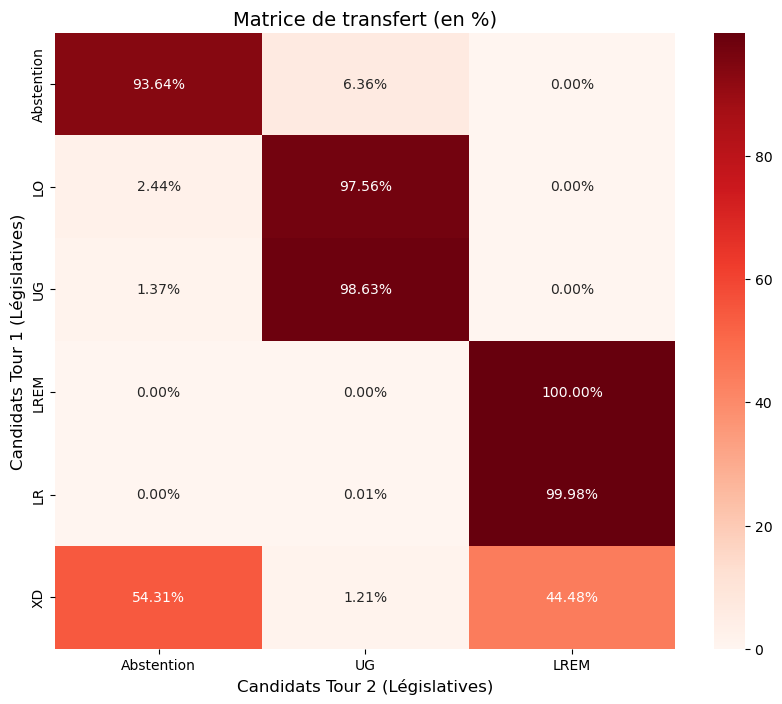

In [873]:
resultsT1 = simu_veran_lfi_T1(var_participation)
X = df22[['% Abs/Ins_T1', '% VINS_LO_T1','% VINS_UG_T1','% VINS_LREM_T1', '% VINS_LR_T1', '% VINS_XD_T1']]
y = df22[['% Abs/Ins_T2', '% VINS_UG_T2', '% VINS_LREM_T2']]
transfert_matrix = ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6)
plot_transfer_matrix(transfert_matrix)

In [547]:
resultsT1['% Abs'] = (1 -  resultsT1['% Exprimés']) / 100
to_product = resultsT1[['% Abs', '% VINSC_LREM', '% VINSC_UG', '% VINSC_LR', '% VINSC_LO','% VINSC_UXD']]
[transfert_matrix.shape, to_product.shape]

[(6, 3), (87, 6)]

In [562]:
df22.columns

Index(['index_left', 'Code commune', 'Code BV', 'Inscrits_T1',
       'Abstentions_T1', '% Abs/Ins_T1', 'Votants_T1', '% Votants/Ins_T1',
       'Blancs_T1', '% Blancs/Vot_T1', 'Exprimés_T1', '% Exp/Vot_T1',
       'Voix_LO_T1', '% VINS_LO_T1', '% VEXP_LO_T1', 'Voix_UG_T1',
       '% VINS_UG_T1', '% VEXP_UG_T1', 'Voix_LREM_T1', '% VINS_LREM_T1',
       '% VEXP_LREM_T1', 'Voix_LR_T1', '% VINS_LR_T1', '% VEXP_LR_T1',
       'Voix_REC_T1', '% VINS_REC_T1', '% VEXP_REC_T1', 'Voix_RN_T1',
       '% VINS_RN_T1', '% VEXP_RN_T1', 'index_right', 'Inscrits_T2',
       'Abstentions_T2', '% Abs/Ins_T2', 'Votants_T2', '% Votants/Ins_T2',
       'Blancs_T2', '% Blancs/Vot_T2', 'Exprimés_T2', '% Exp/Vot_T2',
       'Voix_UG_T2', '% VINS_UG_T2', '% VEXP_UG_T2', 'Voix_LREM_T2',
       '% VINS_LREM_T2', '% VEXP_LREM_T2', 'Voix_XD_T1', '% VINS_XD_T1',
       '% VEXP_XD_T1'],
      dtype='object')

On va donc essayer de comprendre le report de voix 

In [874]:
def simu_veran_lfi_T2(var_function_abs):

    #Récupération de simulation de premier tour et estimation de la matrice de transfert grâce aux données de 2022
    resultsT1 = simu_veran_lfi_T1(var_function_abs)
    X = df22[['% Abs/Ins_T1', '% VINS_LREM_T1','% VINS_UG_T1','% VINS_LR_T1', '% VINS_LO_T1', '% VINS_XD_T1']]
    y = df22[['% Abs/Ins_T2', '% VINS_LREM_T2','% VINS_UG_T2']]
    transfert_matrix = ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6)

    #Calcul des nouveaux résultats
    resultsT1['% Abs'] = (1 -  resultsT1['% Exprimés']/100)
    to_product = resultsT1[['% Abs', '% VINSC_LREM', '% VINSC_UG', '% VINSC_LR', '% VINSC_LO','% VINSC_UXD']]
    df_results2 = transfert_matrix.T @ to_product.T

    #Formalisation des résultats pour coller à la fonction sum_ressimu
    df_results2 = df_results2.T
    colonne_name = ['% Abstention', '% LREM/Ins', '% UG/Ins']
    df_results2.columns = colonne_name
    df_results2['Inscrits'] = resultsT1['Inscrits']
    df_results2['% Exprimés'] = 1 - df_results2['% Abstention']
    df_results2['Exprimés'] = resultsT1['Inscrits'] * df_results2['% Exprimés'] 
    df_results2['Voix_LREM'] = df_results2['% LREM/Ins'] * resultsT1['Inscrits'] 
    df_results2['Voix_UG'] = df_results2['% UG/Ins'] * resultsT1['Inscrits'] 
    
    return df_results2

def sum_ressimu_T2(simu, var_function_abs):
    #Récupération des résultats
    df_results=simu(var_function_abs)

    #Calcul des totaux
    total_exp = df_results['Exprimés'].sum()
    total_inscrits = df_results['Inscrits'].sum()
    total_voixLREM = df_results['Voix_LREM'].sum()
    total_voixUG = df_results['Voix_UG'].sum()

    #Calcul des pourcentages 
    Abs = 1 - (total_exp/total_inscrits) 
    
    inscr_LREM = total_voixLREM/total_inscrits *100
    inscr_UG = total_voixUG/total_inscrits *100

    exp_LREM = total_voixLREM/total_exp *100
    exp_UG = total_voixUG/total_exp *100

    df_total = pd.DataFrame({
        'Total_Voix': [total_voixLREM, total_voixUG],
        'Pourcentage_Inscrits': [inscr_LREM, inscr_UG],
        'Pourcentage_Exp': [exp_LREM, exp_UG]
    }, index=['LREM','UG'])

    df_total.loc['Abstention'] = ['x', Abs, 'x'] 

    return df_total
    

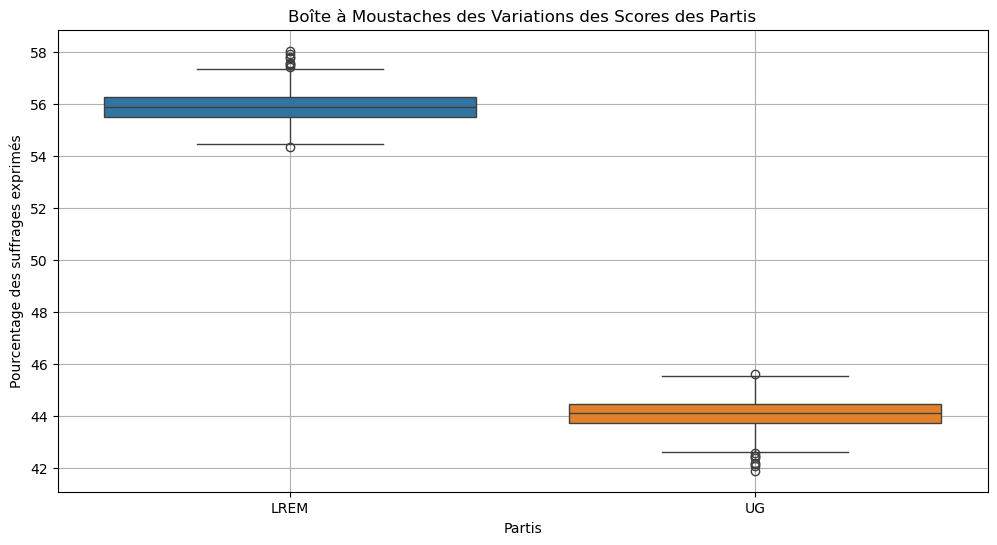

In [880]:
def run_multiple_simulations2(n_simulations, simu, var_function_abs):
    results = {
        'LREM': [],
        'UG': [],
    }

    for _ in range(n_simulations):
        df_total = sum_ressimu_T2(simu, var_function_abs)
        
        # Collecte des scores pour chaque parti
        results['LREM'].append(df_total.loc['LREM', 'Pourcentage_Exp'])
        results['UG'].append(df_total.loc['UG', 'Pourcentage_Exp'])

    return pd.DataFrame(results)

n_simulations = 1000  # Nombre de simulations
df_results = run_multiple_simulations2(n_simulations, simu_veran_lfi_T2, var_participation)

# Création de la boîte à moustaches
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results)
plt.title('Boîte à Moustaches des Variations des Scores des Partis')
plt.xlabel('Partis')
plt.ylabel('Pourcentage des suffrages exprimés')
plt.grid()
plt.savefig('graphiques/ResultsT2DuelLFILREM.jpg')
plt.show()

In [ ]:
n_simulations = 1000  # Nombre de simulations
df_results = run_multiple_simulations2(n_simulations, simu_veran_lfi_T2, var_participation_penalite)

# Création de la boîte à moustaches
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results)
plt.title('Boîte à Moustaches des Variations des Scores des Partis')
plt.xlabel('Partis')
plt.ylabel('Pourcentage des suffrages exprimés')
plt.grid()
plt.show()

Si les reports sont identifiques à 2022, on a perdu. Les électeurs d'extrême-droite préfèrent l'abstention ou LREM au NFP. 

Désormais, nous allons tester le scénario où on a une candidature dissidente PS. Pour ce faire, nous allons nous baser sur les reports entre les européennes et les législatives sur une circonscription attribuée à LFI ayant subi une candidature PS. 

Nous avons décidé de sélectionner la 1ère circonscription des Pyrénées-Atlantiques : en dehors d'une candidature TUPV, les candidats seraient similaires à une dissidence en isère (LO, NFP-LFI, GDS diss (proche de PS), Ensemble, LR, RN). Parmi les circonscriptions ayant présenté des dissidences, c'est une des plus proches, même s'il faut noter que le RN y est plus fort qu'en Isère. Cette circonscription semble davantage ancrée à droite. Mais nous n'aurons pas de meilleure approximation. Nous avons donc calculé les matrices de report en négligeant la candidature TUPV

In [881]:
#Importation des données
legi24T1 = pd.read_excel('data/LEGI24T1.xlsx', engine='openpyxl')
euro24 = pd.read_excel('data/EURO24.xlsx')

In [882]:
legi24T1_64C1 = legi24T1[legi24T1['Nom candidat 1'] == 'LALANNE']
legi24T1_64C1

,Code département,Libellé département,Code commune,Libellé commune,Code BV,Inscrits,Votants,% Votants,Abstentions,% Abstentions,...,Elu 18,Numéro de panneau 19,Nuance candidat 19,Nom candidat 19,Prénom candidat 19,Sexe candidat 19,Voix 19,% Voix/inscrits 19,% Voix/exprimés 19,Elu 19
43953,64,Pyrénées-Atlantiques,64037,Arbus,1,990,747,"75,45%",243,"24,55%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43978,64,Pyrénées-Atlantiques,64060,Artiguelouve,1,823,621,"75,46%",202,"24,54%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43979,64,Pyrénées-Atlantiques,64060,Artiguelouve,2,703,549,"78,09%",154,"21,91%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44006,64,Pyrénées-Atlantiques,64080,Aussevielle,1,725,562,"77,52%",163,"22,48%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44079,64,Pyrénées-Atlantiques,64121,Beyrie-en-Béarn,1,148,116,"78,38%",32,"21,62%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44694,64,Pyrénées-Atlantiques,64511,Sauvagnon,1,1432,1077,"75,21%",355,"24,79%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44695,64,Pyrénées-Atlantiques,64511,Sauvagnon,2,1277,972,"76,12%",305,"23,88%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44711,64,Pyrénées-Atlantiques,64525,Siros,1,615,471,"76,59%",144,"23,41%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44751,64,Pyrénées-Atlantiques,64549,Uzein,1,900,689,"76,56%",211,"23,44%",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [883]:
legi24T1_64C1 = legi24T1_64C1.dropna(how='all', inplace=False, axis=1)

In [884]:
legi24T1_C1 = legi24T1_64C1.copy()

legit1_final = pd.DataFrame({
    'Code commune' : legi24T1_C1['Code commune'],
    'Libellé commune' : legi24T1_C1['Libellé commune'],
    'Code BV' : legi24T1_C1['Code BV'],
    'Inscrits_LegiT1' : legi24T1_C1['Inscrits'], 
    'Votants_LegiT1' : legi24T1_C1['Votants'], 
    '% Votants_LegiT1' : legi24T1_C1['% Votants'], 
    'Abstention_LegiT1' : legi24T1_C1['Abstentions'], 
    '% Abstentions_LegiT1' : legi24T1_C1['% Abstentions'],
    'Exprimés_LegiT1' : legi24T1_C1['Exprimés'],
    'Blancs_LegiT1' : legi24T1_C1['Blancs'],
    'Nuls_LegiT1' : legi24T1_C1['Nuls'],
    'Voix_GDS_LegiT1' : legi24T1_C1['Voix 1'], 
    '% VINSC_GDS_LegiT1' : legi24T1_C1['% Voix/inscrits 1'], 
    '% VEXP_GDS_LegiT1' : legi24T1_C1['% Voix/exprimés 1'], 
     'Voix_LO_LegiT1' : legi24T1_C1['Voix 2'], 
    '% VINSC_LO_LegiT1' : legi24T1_C1['% Voix/inscrits 2'], 
    '% VEXP_LO_LegiT1' : legi24T1_C1['% Voix/exprimés 2'], 
     'Voix_LREM_LegiT1' : legi24T1_C1['Voix 3'], 
    '% VINSC_LREM_LegiT1' : legi24T1_C1['% Voix/inscrits 3'], 
    '% VEXP_LREM_LegiT1' : legi24T1_C1['% Voix/exprimés 3'], 
     'Voix_UG_LegiT1' : legi24T1_C1['Voix 4'], 
    '% VINSC_UG_LegiT1' : legi24T1_C1['% Voix/inscrits 4'], 
    '% VEXP_UG_LegiT1' : legi24T1_C1['% Voix/exprimés 4'], 
    'Voix_TUPV_LegiT1' : legi24T1_C1['Voix 5'], 
    '% VINSC_TUPV_LegiT1' : legi24T1_C1['% Voix/inscrits 5'], 
    '% VEXP_TUPV_LegiT1' : legi24T1_C1['% Voix/exprimés 5'], 
    'Voix_LR_LegiT1' : legi24T1_C1['Voix 6'], 
    '% VINSC_LR_LegiT1' : legi24T1_C1['% Voix/inscrits 6'], 
    '% VEXP_LR_LegiT1' : legi24T1_C1['% Voix/exprimés 6'], 
    'Voix_RN_LegiT1' : legi24T1_C1['Voix 7'], 
    '% VINSC_RN_LegiT1' : legi24T1_C1['% Voix/inscrits 7'], 
    '% VEXP_RN_LegiT1' : legi24T1_C1['% Voix/exprimés 7']
})

In [885]:
legit1_final['Code BV'] = legit1_final['Code BV'].astype(str).str.zfill(4)
euro24['Code BV'] = euro24['Code BV'].astype(str).str.zfill(4)
legit1_final['Code BV'] = legit1_final['Code BV'].astype(str)
legit1_final['Code commune'] = legit1_final['Code commune'].astype(str)
euro24['Code BV'] = euro24['Code BV'].astype(str)
euro24['Code commune'] = euro24['Code commune'].astype(str)
legit1_final['id_bv'] = legit1_final['Code commune'].astype(str) + legit1_final['Code BV'].astype(str)
euro24['id_bv'] = euro24['Code commune'].astype(str) + euro24['Code BV'].astype(str)
final_df = legit1_final.merge(euro24, on='id_bv', how='left')

final_df

,Code commune_x,Libellé commune_x,Code BV_x,Inscrits_LegiT1,Votants_LegiT1,% Votants_LegiT1,Abstention_LegiT1,% Abstentions_LegiT1,Exprimés_LegiT1,Blancs_LegiT1,...,% Voix/exprimés 37,Sièges 37,Numéro de panneau 38,Nuance liste 38,Libellé abrégé de liste 38,Libellé de liste 38,Voix 38,% Voix/inscrits 38,% Voix/exprimés 38,Sièges 38
0,64037,Arbus,0001,990,747,"75,45%",243,"24,55%",727,17,...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
1,64060,Artiguelouve,0001,823,621,"75,46%",202,"24,54%",604,16,...,"0,43%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
2,64060,Artiguelouve,0002,703,549,"78,09%",154,"21,91%",534,6,...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
3,64080,Aussevielle,0001,725,562,"77,52%",163,"22,48%",547,11,...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
4,64121,Beyrie-en-Béarn,0001,148,116,"78,38%",32,"21,62%",115,0,...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,64511,Sauvagnon,0001,1432,1077,"75,21%",355,"24,79%",1052,20,...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
81,64511,Sauvagnon,0002,1277,972,"76,12%",305,"23,88%",944,22,...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
82,64525,Siros,0001,615,471,"76,59%",144,"23,41%",460,10,...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0
83,64549,Uzein,0001,900,689,"76,56%",211,"23,44%",670,15,...,"0,00%",0,38,LDIV,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,LIBERTÉ DÉMOCRATIQUE FRANÇAISE,0,"0,00%","0,00%",0


In [886]:
num_drop = [f'Numéro de panneau {i}' for i in range(1, 39)] 
libab_drop = [f'Libellé abrégé de liste {i}' for i in range(1, 39)] 
lib_drop = [f'Libellé de liste {i}' for i in range(1, 39)] 
siege_drop = [f'Sièges {i}' for i in range(1, 39)] 

euro_drop = num_drop + libab_drop + lib_drop + siege_drop

final_df = final_df.drop(columns=euro_drop)

def is_percentage(val):
    return isinstance(val, str) and '%' in val

def convert_percentage(val):
    if is_percentage(val):
        return float(val.replace(',', '.').replace('%', '')) / 100
    return val 

# Convertir toutes les colonnes de pourcentages en valeurs numériques
df_numeric = final_df.map(convert_percentage)

numeric_cols = df_numeric.select_dtypes(include='number')

# Identifier les colonnes à exclure (où toutes les valeurs sont < 0,01)
cols_to_drop = numeric_cols.columns[(numeric_cols < 0.015).all()]
cols_to_drop

Index(['% VINSC_LO_LegiT1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1',
       'Voix 2', '% Voix/inscrits 2', '% Voix/exprimés 2', '% Voix/inscrits 7',
       '% Voix/exprimés 7', 'Voix 9', '% Voix/inscrits 9', '% Voix/exprimés 9',
       '% Voix/inscrits 12', '% Voix/exprimés 12', '% Voix/inscrits 13',
       '% Voix/inscrits 14', '% Voix/inscrits 15', '% Voix/inscrits 16',
       '% Voix/exprimés 16', '% Voix/inscrits 17', '% Voix/exprimés 17',
       '% Voix/inscrits 19', '% Voix/inscrits 20', '% Voix/exprimés 20',
       '% Voix/inscrits 21', '% Voix/exprimés 21', '% Voix/inscrits 22',
       '% Voix/exprimés 22', '% Voix/inscrits 23', '% Voix/exprimés 23',
       '% Voix/inscrits 24', 'Voix 25', '% Voix/inscrits 25',
       '% Voix/exprimés 25', '% Voix/inscrits 26', '% Voix/exprimés 26',
       'Voix 28', '% Voix/inscrits 28', '% Voix/exprimés 28',
       '% Voix/inscrits 30', '% Voix/exprimés 30', '% Voix/inscrits 31',
       '% Voix/exprimés 31', '% Voix/inscrits 32', '

In [887]:
cols_to_drop = ['Nuance liste 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1', 'Nuance liste 2', 'Voix 2', '% Voix/inscrits 2', '% Voix/exprimés 2',   'Nuance liste 7', 'Voix 7', '% Voix/inscrits 7', '% Voix/exprimés 7',  
                '% Voix/inscrits 9', '% Voix/exprimés 9', 'Nuance liste 9', 'Voix 9', '% Voix/inscrits 12', '% Voix/exprimés 12', 'Nuance liste 12', 'Voix 12', 
       '% Voix/inscrits 16', '% Voix/exprimés 16', 'Nuance liste 16', 'Voix 16', '% Voix/inscrits 17', '% Voix/exprimés 17', 'Nuance liste 17', 'Voix 17', 
                '% Voix/inscrits 20', '% Voix/exprimés 20', 'Nuance liste 20', 'Voix 20', 
       '% Voix/inscrits 21', '% Voix/exprimés 21', 'Nuance liste 21', 'Voix 21', '% Voix/inscrits 22',
       '% Voix/exprimés 22', 'Nuance liste 22', 'Voix 22', '% Voix/inscrits 23', '% Voix/exprimés 23', 'Nuance liste 23', 'Voix 23', '% Voix/inscrits 25', '% Voix/exprimés 25',
                'Nuance liste 25', 'Voix 25', '% Voix/inscrits 26', '% Voix/exprimés 26', 'Nuance liste 26', 'Voix 26', '% Voix/inscrits 28',
       '% Voix/exprimés 28', 'Nuance liste 28', 'Voix 28', 
       '% Voix/inscrits 30', '% Voix/exprimés 30', 'Nuance liste 30', 'Voix 30', '% Voix/inscrits 31',
       '% Voix/exprimés 31', 'Nuance liste 31', 'Voix 31', '% Voix/inscrits 32', '% Voix/exprimés 32', 'Nuance liste 32', 'Voix 32',
       '% Voix/inscrits 34', '% Voix/exprimés 34', 'Nuance liste 34', 'Voix 34', '% Voix/inscrits 36', '% Voix/exprimés 36', 'Nuance liste 36', 'Voix 36', '% Voix/inscrits 37',
       '% Voix/exprimés 37', 'Nuance liste 37', 'Voix 37', '% Voix/inscrits 38', '% Voix/exprimés 38', 'Nuance liste 38', 'Voix 38' ]

final_df = final_df.drop(columns=cols_to_drop)

In [888]:
df_part1 = final_df[final_df.columns[:33]] #Score légi
df_part2 = final_df[final_df.columns[32:]] #Score Euro

In [889]:
euro24_C1_clean = df_part2.copy()

euro_final = pd.DataFrame({
    'id_bv' : euro24_C1_clean['id_bv'], 
    'Inscrits_Euro' : euro24_C1_clean['Inscrits'],
    'Votants_Euro' : euro24_C1_clean['Votants'], 
    '% Votants_Euro' : euro24_C1_clean['% Votants'],
    'Abstention_Euro' : euro24_C1_clean['Abstentions'], 
    '% Abstention_Euro' : euro24_C1_clean['% Abstentions'],
    'Exp_Euro' : euro24_C1_clean['Exprimés'],
    'Blancs_Euro' : euro24_C1_clean['Blancs'],
    'Nuls_Euro' : euro24_C1_clean['Nuls'],
    'Voix_REC_Euro' :  euro24_C1_clean['Voix 3'],
    '% VINSC_REC_Euro' :  euro24_C1_clean['% Voix/inscrits 3'],
    '% VEXP_REC_Euro' :  euro24_C1_clean['% Voix/exprimés 3'],
    'Voix_LFI_Euro' :  euro24_C1_clean['Voix 4'],
    '% VINSC_LFI_Euro' :  euro24_C1_clean['% Voix/inscrits 4'],
    '% VEXP_LFI_Euro' :  euro24_C1_clean['% Voix/exprimés 4'],
    'Voix_RN_Euro' :  euro24_C1_clean['Voix 5'],
    '% VINSC_RN_Euro' :  euro24_C1_clean['% Voix/inscrits 5'],
    '% VEXP_RN_Euro' :  euro24_C1_clean['% Voix/exprimés 5'],
    'Voix_EELV_Euro' :  euro24_C1_clean['Voix 6'],
    '% VINSC_EELV_Euro' :  euro24_C1_clean['% Voix/inscrits 6'],
    '% VEXP_EELV_Euro' :  euro24_C1_clean['% Voix/exprimés 6'],
    'Voix_ANIM_Euro' : euro24_C1_clean['Voix 8'],
    '% VINSC_ANIM_Euro' :  euro24_C1_clean['% Voix/inscrits 8'],
    '% VEXP_ANIM_Euro' :  euro24_C1_clean['% Voix/exprimés 8'],
    'Voix_PIRATE_Euro' : euro24_C1_clean['Voix 10'],
    '% VINSC_PIRATE_Euro' :  euro24_C1_clean['% Voix/inscrits 10'],
    '% VEXP_PIRATE_Euro' :  euro24_C1_clean['% Voix/exprimés 10'],
    'Voix_LREM_Euro' :  euro24_C1_clean['Voix 11'],
    '% VINSC_LREM_Euro' :  euro24_C1_clean['% Voix/inscrits 11'],
    '% VEXP_LREM_Euro' :  euro24_C1_clean['% Voix/exprimés 11'],
     'Voix_EQUI_Euro' :  euro24_C1_clean['Voix 13'],
    '% VINSC_EQUI_Euro' :  euro24_C1_clean['% Voix/inscrits 13'],
    '% VEXP_EQUI_Euro' :  euro24_C1_clean['% Voix/exprimés 13'],
    'Voix_LECO_Euro' :  euro24_C1_clean['Voix 14'], #Ecologie positive et Territoires
    '% VINSC_LECO_Euro' :  euro24_C1_clean['% Voix/inscrits 14'],
    '% VEXP_LECO_Euro' :  euro24_C1_clean['% Voix/exprimés 14'],
    'Voix_UPR_Euro' :  euro24_C1_clean['Voix 15'], #Asselineau
    '% VINSC_UPR_Euro' :  euro24_C1_clean['% Voix/inscrits 15'],
    '% VEXP_UPR_Euro' :  euro24_C1_clean['% Voix/exprimés 15'],
    'Voix_LR_Euro' :  euro24_C1_clean['Voix 18'],
    '% VINSC_LR_Euro' :  euro24_C1_clean['% Voix/inscrits 18'],
    '% VEXP_LR_Euro' :  euro24_C1_clean['% Voix/exprimés 18'],
    'Voix_LO_Euro' :  euro24_C1_clean['Voix 19'],
    '% VINSC_LO_Euro' :  euro24_C1_clean['% Voix/inscrits 19'],
    '% VEXP_LO_Euro' :  euro24_C1_clean['% Voix/exprimés 19'],
    'Voix_PHIL_Euro' :  euro24_C1_clean['Voix 24'],
    '% VINSC_PHIL_Euro' :  euro24_C1_clean['% Voix/inscrits 24'],
    '% VEXP_PHIL_Euro' :  euro24_C1_clean['% Voix/exprimés 24'],
    'Voix_PP_Euro' :  euro24_C1_clean['Voix 27'], #Place Publique
    '% VINSC_PP_Euro' :  euro24_C1_clean['% Voix/inscrits 27'],
    '% VEXP_PP_Euro' :  euro24_C1_clean['% Voix/exprimés 27'],
     'Voix_AR_Euro' :  euro24_C1_clean['Voix 29'], #Alliance rurale 
    '% VINSC_AR_Euro' :  euro24_C1_clean['% Voix/inscrits 29'],
    '% VEXP_AR_Euro' :  euro24_C1_clean['% Voix/exprimés 29'],
    'Voix_PCF_Euro' :  euro24_C1_clean['Voix 33'],
    '% VINSC_PCF_Euro' :  euro24_C1_clean['% Voix/inscrits 33'],
    '% VEXP_PCF_Euro' :  euro24_C1_clean['% Voix/exprimés 33'],
    'Voix_ECOC_Euro' :  euro24_C1_clean['Voix 35'], #Ecologie au centre
    '% VINSC_ECOC_Euro' :  euro24_C1_clean['% Voix/inscrits 35'],
    '% VEXP_ECOC_Euro' :  euro24_C1_clean['% Voix/exprimés 35'],
})


In [890]:
df_64C1 = df_part1.merge(euro_final, on='id_bv', how='left')
df_64C1.to_excel('data/transformed/circo641.xlsx') 

In [897]:
df_64C1 = pd.read_excel('data/transformed/circo641.xlsx')

def ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6):
    """
    Méthode itérative pour estimer la matrice de transfert
    """
     # Conversion en matrices NumPy si ce sont des DataFrames Pandas
    n_bureaux, n_cand_t1 = X.shape
    n_cand_t2 = y.shape[1]
    
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.DataFrame) else y
    
    # 1. Initialisation de la matrice de transfert
    T = np.ones((n_cand_t1, n_cand_t2)) / n_cand_t2
    
    for iter in range(max_iter):
        T_old = T.copy()
        
        # 2. Contrainte sur Y (colonnes)
        Y_hat = X @ T  # votes prédits
        col_adjust = y / Y_hat
        T = T * (X.T @ col_adjust / X.sum(axis=0).reshape(-1, 1))
        
        # 3. Normalisation (somme des lignes = 1)
        row_sums = T.sum(axis=1, keepdims=True)
        T = T / row_sums
        
        # Convergence
        if np.max(np.abs(T - T_old)) < tol:
            break
            
    return T

def plot_transfer_matrix(T):
    """Affiche la matrice de transfert uniquement avec des couleurs rouges, des labels personnalisés, et les chiffres en pourcentage"""
    plt.figure(figsize=(10, 8))
    
    # Définir les labels pour les lignes (candidats du premier tour) et colonnes (candidats du second tour)
    labels_X = ['Abstention',  'LFI', 'PCF', 'EELV', 'PS-PP', 'PIRATE', 'EQUINOXE', 'ANIMALISTE', 'ECOLOGIE AU CENTRE',
               'LREM', 'LR', 'RN', 'UPR', 'REC']
    labels_y = ['Abstention', 'LO', 'NFP-LFI', 'DVG DISS', 'LREM', 'LR', 'RN']
    
      # Préparer les annotations manuellement pour ajouter le symbole %
    annot = np.array([["{:.2f}%".format(val * 100) for val in row] for row in T])

    # Affichage de la heatmap avec les chiffres, couleurs rouges et étiquettes personnalisées
    sns.heatmap(T * 100, annot=annot, fmt='', cmap="Reds", xticklabels=labels_y, yticklabels=labels_X)
    
    # Configuration des titres et labels d'axes
    plt.title('Matrice de transfert (en %)', fontsize=14)
    plt.xlabel("Candidats Tour 1 (Législatives)", fontsize=12)
    plt.ylabel("Candidats Tour 1 (Européennes)", fontsize=12)

    plt.savefig('graphiques/report_641_eurolegi.jpg') #Le nom est changé pour stocker la matrice de base puis la matrice corrigée
    
    plt.show()

/tmp/ipykernel_10038/890753626.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10038/890753626.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



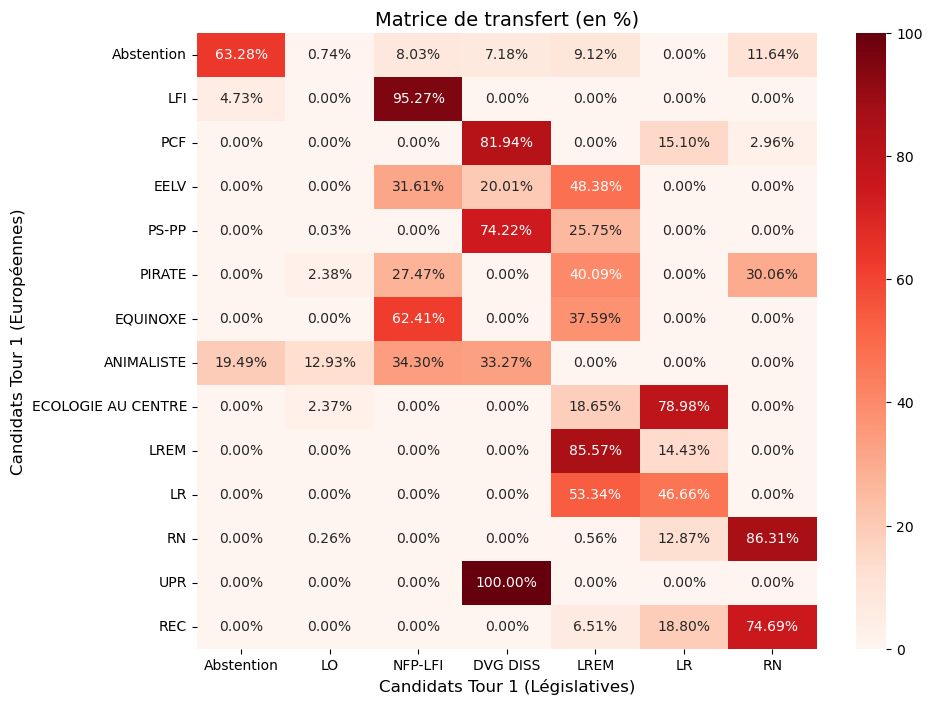

In [898]:
df_64C1 = df_64C1.map(convert_percentage)

X = df_64C1[['% Abstention_Euro', '% VINSC_LFI_Euro', '% VINSC_PCF_Euro', '% VINSC_EELV_Euro',  '% VINSC_PP_Euro', '% VINSC_PIRATE_Euro', '% VINSC_EQUI_Euro',
        '% VINSC_ANIM_Euro', '% VINSC_ECOC_Euro', '% VINSC_LREM_Euro',  '% VINSC_LR_Euro', 
        '% VINSC_RN_Euro',  '% VINSC_UPR_Euro', '% VINSC_REC_Euro']]
y = df_64C1[['% Abstentions_LegiT1', '% VINSC_LO_LegiT1', '% VINSC_UG_LegiT1', '% VINSC_GDS_LegiT1', '% VINSC_LREM_LegiT1', '% VINSC_LR_LegiT1',
              '% VINSC_RN_LegiT1']]

for col in X.columns:
    X[col] = X[col]/100

for col in y.columns:
    y[col] = y[col]/100


T = ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6)

plot_transfer_matrix(T)

Pour les grands partis, la matrice de reprot est cohérente avec celle de l'Isère sauf EELV qui parait nettement plus macroniste dans les Pyrénées-Atlantiques, on modifiera donc légèrement la matrice de report en réattribuant davntage de voix à gauche aux électeurs EELV. On ajoutera 30% de report pour NFP-LFI et 10% pour le DVG. De plus, EELV soutenant la candidature de Lyes, il est plus logique de supposer davantage de report NFP. On conserve un peu de report macroniste au-cas-où ce phénomène soit lié à de la dissidence. 

Nous allons désormais procéder à une prédiction des résultats du premier tour

In [899]:
df_results2 = T.T @ X.T

#Formalisation des résultats pour coller à la fonction sum_ressimu
df_results2 = df_results2.T
colonne_name = ['% Abstention', '% LO/Ins', '% UG/Ins', '% PSDISS/Ins', '% LREM/Ins', '% LR/Ins', '% RN/Ins']
df_results2.columns = colonne_name
df_results2['Inscrits'] = resultsT1['Inscrits']
df_results2['% Exprimés'] = 1 - df_results2['% Abstention']
df_results2['Exprimés'] = resultsT1['Inscrits'] * df_results2['% Exprimés'] 
df_results2['Voix_LREM'] = df_results2['% LREM/Ins'] * resultsT1['Inscrits'] 
df_results2['Voix_UG'] = df_results2['% UG/Ins'] * resultsT1['Inscrits'] 
df_results2['Voix_LO'] = df_results2['% LO/Ins'] * resultsT1['Inscrits'] 
df_results2['Voix_PSDISS'] = df_results2['% PSDISS/Ins'] * resultsT1['Inscrits'] 
df_results2['Voix_LR'] = df_results2['% LR/Ins'] * resultsT1['Inscrits'] 
    

In [903]:
def simu_veran_lfiPS_T1(var_function_abs): #Fonction augmentant l'abstention à Grenoble 
    df_results = pd.DataFrame()
    df_results['Inscrits'] = df['Inscrits_LegiT2'] #On fixe le nombre d'inscrits
    df['% Exprimés_LegiT1'] = (df['Exprimés_LegiT1']/df['Inscrits_LegiT1']) * 100
    df_results['% Exprimés'] = df.apply(
        lambda row: var_function_abs(row['% Exprimés_LegiT1'], row['Code commune']), axis=1 #On estime le pourcent de votant aléatoirement
    )
    df_results['Exprimés'] = df_results['% Exprimés']/100 * df_results['Inscrits']
    df_results['Exprimés'] = df_results['Exprimés'].apply(lambda x: round(x)) #On arront à l'entier le nombre de votants 

    #Estimation transfert
    X = df_64C1[['% Abstention_Euro', '% VINSC_LFI_Euro', '% VINSC_PCF_Euro', '% VINSC_EELV_Euro',  '% VINSC_PP_Euro', '% VINSC_PIRATE_Euro', '% VINSC_EQUI_Euro',
        '% VINSC_ANIM_Euro', '% VINSC_ECOC_Euro', '% VINSC_LREM_Euro',  '% VINSC_LR_Euro', 
        '% VINSC_RN_Euro',  '% VINSC_UPR_Euro', '% VINSC_REC_Euro']]
    y = df_64C1[['% Abstentions_LegiT1', '% VINSC_LO_LegiT1', '% VINSC_UG_LegiT1', '% VINSC_GDS_LegiT1', '% VINSC_LREM_LegiT1', '% VINSC_LR_LegiT1',
              '% VINSC_RN_LegiT1']]

    for col in X.columns:
        X[col] = X[col]/100

    for col in y.columns:
        y[col] = y[col]/100


    T = ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6)
    

    T[3,2] = T[3,2] +0.3
    T[3,3] = T[3,3] + 0.1
    T[3,4] = T[3,4] -0.4

    #On produit les nouveaux résultats 
    EURO = df[['% Abstention_Euro', '% VINSC_LFI_Euro', '% VINSC_PCF_Euro', '% VINSC_EELV_Euro',  '% VINSC_PP_Euro', '% VINSC_PIRATE_Euro', '% VINSC_EQUI_Euro',
        '% VINSC_ANIM_Euro', '% VINSC_ECOC_Euro', '% VINSC_LREM_Euro',  '% VINSC_LR_Euro', 
        '% VINSC_RN_Euro',  '% VINSC_UPR_Euro', '% VINSC_REC_Euro']]
    df_results2 = T.T @ EURO.T
    df_results2 = df_results2.T
    colonne_name = ['% Abstention', '% LO/Ins', '% UG/Ins', '% PSDISS/Ins', '% LREM/Ins', '% LR/Ins', '% RN/Ins']
    df_results2.columns = colonne_name
    df_results2['Inscrits'] = df_results['Inscrits']
    df_results2['% Exprimés'] = df_results['% Exprimés']
    df_results2['Exprimés'] =  df_results['Exprimés']
    
    #Ajustement nouveau taux d'abstention 
    
    for col in colonne_name[1:]:  # Exclure la colonne '% Abstention'
        df_results2[col] = df_results2[col]/(df['Exprimés_LegiT1']/df['Inscrits_LegiT1']) * (df_results2['% Exprimés']/100)
    df_results2['% Abstention'] = 100 - df_results2['% Exprimés']

    #Il faut corriger les résultats de l'abstention plus forte
    df_results2['id_bv'] =  df['id_bv'] 
    
    df_results2['Voix_LREM'] = df_results2['% LREM/Ins'] * df_results2['Inscrits']/100 
    df_results2['Voix_LR'] = df_results2['% LR/Ins'] * df_results2['Inscrits']/100
    df_results2['Voix_UG'] = df_results2['% UG/Ins'] * df_results2['Inscrits']/100
    df_results2['Voix_PSDISS'] = df_results2['% PSDISS/Ins'] * df_results2['Inscrits']/100
    df_results2['Voix_RN'] = df_results2['% RN/Ins'] * df_results2['Inscrits']/100
    df_results2['Voix_LO'] = df_results2['% LO/Ins'] * df_results2['Inscrits']/100

    #Arrondis
    for col in ['Voix_LREM', 'Voix_LR', 'Voix_UG', 'Voix_LO', 'Voix_PSDISS', 'Voix_RN']:
        df_results2[col] = df_results2[col].apply(lambda x: round(x))

    df_results2['% VEXP_LREM'] = df_results2['Voix_LREM']/df_results2['Exprimés']
    df_results2['% VEXP_LR'] = df_results2['Voix_LR']/df_results2['Exprimés']
    df_results2['% VEXP_LO'] = df_results2['Voix_LO']/df_results2['Exprimés']
    df_results2['% VEXP_UG'] = df_results2['Voix_UG']/df_results2['Exprimés']
    df_results2['% VEXP_RN'] = df_results2['Voix_RN']/df_results2['Exprimés']
    df_results2['% VEXP_RN'] = df_results2['Voix_PSDISS']/df_results2['Exprimés']

    return df_results2

def sum_ressimu(simu, var_function_abs):
    #Récupération des résultats
    df_results=simu(var_function_abs)

    #Calcul des totaux
    total_exp = df_results['Exprimés'].sum()
    total_inscrits = df_results['Inscrits'].sum()
    total_voixLREM = df_results['Voix_LREM'].sum()
    total_voixLR = df_results['Voix_LR'].sum()
    total_voixLO = df_results['Voix_LO'].sum()
    total_voixUXD = df_results['Voix_RN'].sum()
    total_voixUG = df_results['Voix_UG'].sum()
    total_voixPSDISS = df_results['Voix_PSDISS'].sum()

    #Calcul des pourcentages 
    Abs = 1 - (total_exp/total_inscrits) 
    
    inscr_LREM = total_voixLREM/total_inscrits 
    inscr_LR = total_voixLR/total_inscrits 
    inscr_LO = total_voixLO/total_inscrits 
    inscr_UXD = total_voixUXD/total_inscrits
    inscr_UG = total_voixUG/total_inscrits 
    inscr_PSDISS = total_voixPSDISS/total_inscrits 

    exp_LREM = total_voixLREM/total_exp 
    exp_LR = total_voixLR/total_exp 
    exp_LO = total_voixLO/total_exp
    exp_UXD = total_voixUXD/total_exp 
    exp_UG = total_voixUG/total_exp 
    exp_PSDISS = total_voixPSDISS/total_exp 

    df_total = pd.DataFrame({
        'Total_Voix': [total_voixLREM, total_voixLR, total_voixLO, total_voixUXD, total_voixUG, total_voixPSDISS],
        'Pourcentage_Inscrits': [inscr_LREM, inscr_LR, inscr_LO, inscr_UXD, inscr_UG, inscr_PSDISS],
        'Pourcentage_Exp': [exp_LREM, exp_LR, exp_LO, exp_UXD, exp_UG, exp_PSDISS]
    }, index=['LREM', 'LR', 'LO', 'RN', 'UG', 'PSDISS'])

    df_total.loc['Abstention'] = ['x', Abs*100, 'x'] 

    return df_total

In [904]:
simu_veran_lfiPS_T1(var_participation)

/tmp/ipykernel_10038/1028931806.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10038/1028931806.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,% Abstention,% LO/Ins,% UG/Ins,% PSDISS/Ins,% LREM/Ins,% LR/Ins,% RN/Ins,Inscrits,% Exprimés,Exprimés,...,Voix_LR,Voix_UG,Voix_PSDISS,Voix_RN,Voix_LO,% VEXP_LREM,% VEXP_LR,% VEXP_LO,% VEXP_UG,% VEXP_RN
0,41.377552,0.324168,7.833150,12.024131,18.151310,5.644056,11.305845,965,58.622448,566,...,54,76,116,109,3,0.309187,0.095406,0.005300,0.134276,0.204947
1,40.411068,0.286672,8.179679,12.205456,17.653364,5.691798,12.445629,992,59.588932,591,...,56,81,121,123,3,0.296108,0.094755,0.005076,0.137056,0.204738
2,47.302846,0.338291,7.535455,10.737064,14.903911,5.733543,12.608525,980,52.697154,516,...,56,74,105,124,3,0.282946,0.108527,0.005814,0.143411,0.203488
3,44.306145,0.231071,6.483137,10.268215,20.148643,7.377547,10.922079,1037,55.693855,578,...,77,67,106,113,2,0.361592,0.133218,0.003460,0.115917,0.183391
4,41.214017,0.244581,7.100899,11.007612,19.466397,6.698834,12.783772,1032,58.785983,607,...,69,73,114,132,3,0.331137,0.113674,0.004942,0.120264,0.187809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,37.193103,0.286694,15.249063,15.534531,14.967186,4.083546,8.201713,1010,62.806897,634,...,41,154,157,83,3,0.238170,0.064669,0.004732,0.242902,0.247634
83,49.173076,0.352819,12.269109,11.478710,14.261542,4.170136,9.205601,1070,50.826924,544,...,45,131,123,98,4,0.281250,0.082721,0.007353,0.240809,0.226103
84,39.918759,0.254487,10.384181,12.844352,20.163361,6.696202,7.881745,1103,60.081241,663,...,74,115,142,87,3,0.334842,0.111614,0.004525,0.173454,0.214178
85,45.593086,0.384289,12.104033,12.115347,15.027702,4.444456,10.195522,1068,54.406914,581,...,47,129,129,109,4,0.275387,0.080895,0.006885,0.222031,0.222031


In [905]:
sum_ressimu(simu_veran_lfiPS_T1, var_participation)

/tmp/ipykernel_10038/1028931806.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10038/1028931806.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total_Voix,Pourcentage_Inscrits,Pourcentage_Exp
LREM,12451,0.148322,0.270609
LR,3987,0.047495,0.086653
LO,267,0.003181,0.005803
RN,8781,0.104603,0.190846
UG,9957,0.118612,0.216405
PSDISS,10022,0.119386,0.217817
Abstention,x,45.189765,x


In [756]:
sum_ressimu(simu_veran_lfiPS_T1, var_participation_penalite)

/tmp/ipykernel_10038/3689374362.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10038/3689374362.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total_Voix,Pourcentage_Inscrits,Pourcentage_Exp
LREM,1251676,14.910490,27.392568
LR,403477,4.806387,8.829978
LO,26409,0.314595,0.577953
RN,878599,10.466240,19.227885
UG,960986,11.447669,21.030901
PSDISS,988345,11.773581,21.629645
Abstention,x,45.567389,x


Si il y'a une dissidence, le résultat risque d'être serré, il est donc difficile de prévoir qui sera au second tour. En cas de malchance, on pourrait même avoir une qualification du RN. 
Cependant, les méthodes d'esimations étant assez différentes, il est difficile de comparer les 2 scénarii car les données utilisées sont assez différentes. Toutefois, le résultat parait cohérent : le PS dissident aspire des voix de gauche et des macronistes. 

On se basera sur la matrice de report de la deuxième circonscription du Gers en 2022 pour prédire les reports (second tour PS DISS-LREM, avec LFI arrivé 3ème et RN 4ème). On a négligé des petits candidats pour faciliter l'implémentation

In [906]:
legit122 = pd.read_excel('data/Legi22T1.xlsx')
legit222 = pd.read_excel('data/Legi22T2.xlsx')

In [907]:
legit122['Code du département'] = legit122['Code du département'].astype(str)
legit12238 = legit122[legit122['Code du département'] == '32']

legit12238['Code de la circonscription'] = legit12238['Code de la circonscription'].astype(str)
legit122_32C2 = legit12238[legit12238['Code de la circonscription'] == '2']

legit222['Code du département'] = legit222['Code du département'].astype(str)
legit22238 = legit222[legit222['Code du département'] == '32']

legit22238['Code de la circonscription'] = legit22238['Code de la circonscription'].astype(str)
legit222_32C2 = legit22238[legit22238['Code de la circonscription'] == '2']

/tmp/ipykernel_10038/3976644876.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10038/3976644876.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [908]:
legit122_32C2 = legit122_32C2.dropna(how='all', inplace=False, axis=1)

In [909]:
legit122_38C1 = legit122_32C2.copy()

legit122_exp = pd.DataFrame ({
    'Code commune' : legit122_38C1['Code de la commune'],
    'Code BV' : legit122_38C1['Code du b.vote'],
    'Inscrits_T1' : legit122_38C1['Inscrits'],
    'Abstentions_T1' : legit122_38C1['Abstentions'],
    '% Abs/Ins_T1' : legit122_38C1['% Abs/Ins'],
    'Votants_T1' : legit122_38C1['Votants'],
    '% Votants/Ins_T1' : legit122_38C1['% Vot/Ins'],
    'Blancs_T1' : legit122_38C1['Blancs'],
    '% Blancs/Vot_T1' : legit122_38C1['% Blancs/Vot'],
    'Exprimés_T1' : legit122_38C1['Exprimés'],
    '% Exp/Vot_T1' : legit122_38C1['% Exp/Vot'],
    'Voix_DXG_T1' : legit122_38C1['Voix'] + legit122_38C1['Unnamed: 34'], #On additionner POID et LO
    '% VINS_DXG_T1' : legit122_38C1['% Voix/Ins'] + legit122_38C1['Unnamed: 35'],
    '% VEXP_DXG_T1' : legit122_38C1['% Voix/Exp']+ legit122_38C1['Unnamed: 36'],
    'Voix_UG_T1' : legit122_38C1['Unnamed: 42'],
    '% VINS_UG_T1' : legit122_38C1['Unnamed: 43'],
    '% VEXP_UG_T1' : legit122_38C1['Unnamed: 44'],
    'Voix_DVG_T1' : legit122_38C1['Unnamed: 58'],
    '% VINS_DVG_T1' : legit122_38C1['Unnamed: 59'],
    '% VEXP_DVG_T1' : legit122_38C1['Unnamed: 60'],
    'Voix_LREM_T1' : legit122_38C1['Unnamed: 98'], #Changer nombre
    '% VINS_LREM_T1' : legit122_38C1['Unnamed: 99'],
    '% VEXP_LREM_T1' : legit122_38C1['Unnamed: 100'],
    'Voix_LR_T1' : legit122_38C1['Unnamed: 105'], 
    '% VINS_LR_T1' : legit122_38C1['Unnamed: 106'],
    '% VEXP_LR_T1' : legit122_38C1['Unnamed: 107'],
    'Voix_XD_T1' : legit122_38C1['Unnamed: 114'] + legit122_38C1['Unnamed: 122'] + legit122_38C1['Unnamed: 130'], #On somme Les patriotes, RN et REC dans extrême-droite
    '% VINS_XD_T1' : legit122_38C1['Unnamed: 115'] + legit122_38C1['Unnamed: 123'] + legit122_38C1['Unnamed: 131'],
    '% VEXP_XD_T1' : legit122_38C1['Unnamed: 116'] + legit122_38C1['Unnamed: 124'] + legit122_38C1['Unnamed: 132']
})



In [910]:
legit122_exp 

,Code commune,Code BV,Inscrits_T1,Abstentions_T1,% Abs/Ins_T1,Votants_T1,% Votants/Ins_T1,Blancs_T1,% Blancs/Vot_T1,Exprimés_T1,...,% VEXP_DVG_T1,Voix_LREM_T1,% VINS_LREM_T1,% VEXP_LREM_T1,Voix_LR_T1,% VINS_LR_T1,% VEXP_LR_T1,Voix_XD_T1,% VINS_XD_T1,% VEXP_XD_T1
19798,2,0001,73,20,27.40,53,72.60,3,5.66,50,...,20.00,9.0,12.33,18.00,LR,5.0,6.85,16.0,21.92,32.00
19799,3,0001,42,10,23.81,32,76.19,0,0.00,32,...,9.38,9.0,21.43,28.13,LR,4.0,9.52,10.0,23.81,31.26
19802,7,0001,188,86,45.74,102,54.26,4,3.92,98,...,25.51,18.0,9.57,18.37,LR,7.0,3.72,23.0,12.23,23.47
19806,12,0001,893,414,46.36,479,53.64,8,1.67,469,...,25.37,113.0,12.65,24.09,LR,32.0,3.58,102.0,11.42,21.74
19823,16,0001,565,242,42.83,323,57.17,13,4.02,308,...,10.06,61.0,10.80,19.81,LR,34.0,6.02,95.0,16.82,30.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20296,462,0001,932,440,47.21,492,52.79,13,2.64,472,...,21.82,107.0,11.48,22.67,LR,74.0,7.94,94.0,10.08,19.91
20297,462,0002,824,413,50.12,411,49.88,12,2.92,390,...,21.28,103.0,12.50,26.41,LR,62.0,7.52,87.0,10.56,22.30
20298,462,0003,841,401,47.68,440,52.32,16,3.64,422,...,16.82,81.0,9.63,19.19,LR,82.0,9.75,95.0,11.29,22.51
20299,462,0004,86,26,30.23,60,69.77,1,1.67,59,...,13.56,20.0,23.26,33.90,LR,11.0,12.79,10.0,11.63,16.94


In [911]:
legit222_32C2 = legit222_32C2.dropna(how='all', inplace=False, axis=1)

In [912]:
legit222_38C1 = legit222_32C2.copy()

legit222_exp = pd.DataFrame ({
    'Inscrits_T2' : legit222_38C1['Inscrits'],
    'Abstentions_T2' : legit222_38C1['Abstentions'],
    '% Abs/Ins_T2' : legit222_38C1['% Abs/Ins'],
    'Votants_T2' : legit222_38C1['Votants'],
    '% Votants/Ins_T2' : legit222_38C1['% Vot/Ins'],
    'Blancs_T2' : legit222_38C1['Blancs'],
    '% Blancs/Vot_T2' : legit222_38C1['% Blancs/Vot'],
    'Exprimés_T2' : legit222_38C1['Exprimés'],
    '% Exp/Vot_T2' : legit222_38C1['% Exp/Vot'],
    'Voix_DVG_T2' : legit222_38C1['Voix'],
    '% VINS_DVG_T2' : legit222_38C1['% Voix/Ins'],
    '% VEXP_DVG_T2' : legit222_38C1['% Voix/Exp'],
    'Voix_LREM_T2' : legit222_38C1['Unnamed: 34'],
    '% VINS_LREM_T2' : legit222_38C1['Unnamed: 35'],
    '% VEXP_LREM_T2' : legit222_38C1['Unnamed: 36']
})

In [913]:
legit122_exp.reset_index(inplace=True)
legit222_exp.reset_index(inplace=True)

df_joined = legit122_exp.join(legit222_exp, how='inner', lsuffix='_left', rsuffix='_right')
df_joined.to_excel('data/transformed/legi2022-322.xlsx', index=False)
df_joined

,index_left,Code commune,Code BV,Inscrits_T1,Abstentions_T1,% Abs/Ins_T1,Votants_T1,% Votants/Ins_T1,Blancs_T1,% Blancs/Vot_T1,...,Blancs_T2,% Blancs/Vot_T2,Exprimés_T2,% Exp/Vot_T2,Voix_DVG_T2,% VINS_DVG_T2,% VEXP_DVG_T2,Voix_LREM_T2,% VINS_LREM_T2,% VEXP_LREM_T2
0,19798,2,0001,73,20,27.40,53,72.60,3,5.66,...,3,6.00,43,86.00,30,41.10,69.77,13.0,17.81,30.23
1,19799,3,0001,42,10,23.81,32,76.19,0,0.00,...,5,26.32,13,68.42,8,19.05,61.54,5.0,11.90,38.46
2,19802,7,0001,188,86,45.74,102,54.26,4,3.92,...,9,9.28,83,85.57,57,30.32,68.67,26.0,13.83,31.33
3,19806,12,0001,893,414,46.36,479,53.64,8,1.67,...,23,5.23,409,92.95,247,27.63,60.39,162.0,18.12,39.61
4,19823,16,0001,565,242,42.83,323,57.17,13,4.02,...,31,10.88,241,84.56,133,23.54,55.19,108.0,19.12,44.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,20296,462,0001,932,440,47.21,492,52.79,13,2.64,...,25,5.41,421,91.13,256,27.44,60.81,165.0,17.68,39.19
224,20297,462,0002,824,413,50.12,411,49.88,12,2.92,...,21,5.25,358,89.50,210,25.52,58.66,148.0,17.98,41.34
225,20298,462,0003,841,401,47.68,440,52.32,16,3.64,...,37,9.25,351,87.75,206,24.49,58.69,145.0,17.24,41.31
226,20299,462,0004,86,26,30.23,60,69.77,1,1.67,...,3,4.92,55,90.16,25,29.07,45.45,30.0,34.88,54.55


In [914]:
def ipf_transfer_matrix(X, y, max_iter=10000, tol=1e-6):
    """
    Méthode itérative pour estimer la matrice de transfert
    """
     # Conversion en matrices NumPy si ce sont des DataFrames Pandas
    n_bureaux, n_cand_t1 = X.shape
    n_cand_t2 = y.shape[1]
    
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.DataFrame) else y
    
    # 1. Initialisation de la matrice de transfert
    T = np.ones((n_cand_t1, n_cand_t2)) / n_cand_t2
    
    for iter in range(max_iter):
        T_old = T.copy()
        
        # 2. Contrainte sur Y (colonnes)
        Y_hat = X @ T  # votes prédits
        col_adjust = y / Y_hat
        T = T * (X.T @ col_adjust / X.sum(axis=0).reshape(-1, 1))
        
        # 3. Normalisation (somme des lignes = 1)
        row_sums = T.sum(axis=1, keepdims=True)
        T = T / row_sums
        
        # Convergence
        if np.max(np.abs(T - T_old)) < tol:
            break
            
    return T

def plot_transfer_matrix(T):
    """Affiche la matrice de transfert uniquement avec des couleurs rouges, des labels personnalisés, et les chiffres en pourcentage"""
    plt.figure(figsize=(10, 8))
    
    # Définir les labels pour les lignes (candidats du premier tour) et colonnes (candidats du second tour)
    labels_X = ['Abstention',  'DXG', 'UG', 'DVG DISS', 'LREM', 'LR', 'XD']
    labels_y = ['Abstention', 'DVG DISS', 'LREM']
    
      # Préparer les annotations manuellement pour ajouter le symbole %
    annot = np.array([["{:.2f}%".format(val * 100) for val in row] for row in T])

    # Affichage de la heatmap avec les chiffres, couleurs rouges et étiquettes personnalisées
    sns.heatmap(T * 100, annot=annot, fmt='', cmap="Reds", xticklabels=labels_y, yticklabels=labels_X)
    
    # Configuration des titres et labels d'axes
    plt.title('Matrice de transfert (en %)', fontsize=14)
    plt.xlabel("Candidats Tour 1 (Législatives)", fontsize=12)
    plt.ylabel("Candidats Tour 2 (Législatives)", fontsize=12)
    
    plt.show()

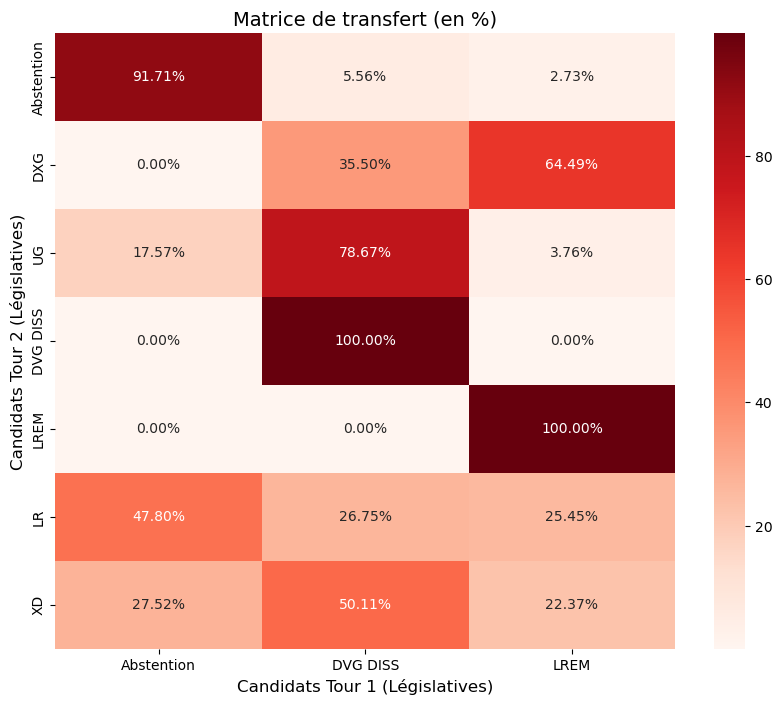

In [915]:
X = df_joined[['% Abs/Ins_T1', '% VINS_DXG_T1','% VINS_UG_T1', '% VINS_DVG_T1', '% VINS_LREM_T1', '% VINS_LR_T1', '% VINS_XD_T1']]
y = df_joined[['% Abs/Ins_T2', '% VINS_DVG_T2', '% VINS_LREM_T2']]
transfert_matrix = ipf_transfer_matrix(X, y, max_iter=100000, tol=1e-6)
plot_transfer_matrix(transfert_matrix)

Les résultats sont assez étonnants : l'extrême droite se reporte pour la moitié sur le divers gauche, alors qu'ils se reportaient plutot sur LREM en 2022 en Isère. Barrage à LFI ou différence régionale ? Difficile de trancher. 

In [917]:
def simu_veran_PS_T2(var_function_abs):

    #Récupération de simulation de premier tour et estimation de la matrice de transfert grâce aux données de 2022
    resultsT1 =     simu_veran_lfiPS_T1(var_function_abs)
    X = df_joined[['% Abs/Ins_T1', '% VINS_DXG_T1','% VINS_UG_T1', '% VINS_DVG_T1', '% VINS_LREM_T1', '% VINS_LR_T1', '% VINS_XD_T1']]
    y = df_joined[['% Abs/Ins_T2', '% VINS_DVG_T2', '% VINS_LREM_T2']]
    transfert_matrix = ipf_transfer_matrix(X, y, max_iter=100000, tol=1e-6)

    #Calcul des nouveaux résultats
    resultsT1['% Abs'] = (1 -  resultsT1['% Exprimés']/100)*100
    to_product = resultsT1[['% Abs', '% LO/Ins', '% UG/Ins', '% PSDISS/Ins', '% LREM/Ins', '% LR/Ins', '% RN/Ins']]
    df_results2 = transfert_matrix.T @ to_product.T

    #Formalisation des résultats pour coller à la fonction sum_ressimu
    df_results2 = df_results2.T
    colonne_name = ['% Abstention', '% PSDISS/Ins', '% LREM/Ins']
    df_results2.columns = colonne_name
    df_results2['Inscrits'] = resultsT1['Inscrits']
    df_results2['% Exprimés'] = 100 - df_results2['% Abstention']
    df_results2['Exprimés'] = resultsT1['Inscrits'] * (df_results2['% Exprimés']/100) 
    df_results2['Voix_LREM'] = df_results2['% LREM/Ins'] * resultsT1['Inscrits']/100
    df_results2['Voix_PSDISS'] = df_results2['% PSDISS/Ins'] * resultsT1['Inscrits']/100

    for col in ['Voix_LREM', 'Voix_PSDISS']:
        df_results2[col] = df_results2[col].apply(lambda x: round(x))
    
    return df_results2

def sum_ressimu_T2(simu, var_function_abs):
    #Récupération des résultats
    df_results=simu(var_function_abs)

    #Calcul des totaux
    total_exp = df_results['Exprimés'].sum()
    total_inscrits = df_results['Inscrits'].sum()
    total_voixLREM = df_results['Voix_LREM'].sum()
    total_voixPSDISS = df_results['Voix_PSDISS'].sum()

    #Calcul des pourcentages 
    Abs = 1 - (total_exp/total_inscrits) 
    
    inscr_LREM = total_voixLREM/total_inscrits 
    inscr_UG = total_voixPSDISS/total_inscrits 

    exp_LREM = total_voixLREM/total_exp 
    exp_UG = total_voixPSDISS/total_exp 

    df_total = pd.DataFrame({
        'Total_Voix': [total_voixLREM, total_voixPSDISS],
        'Pourcentage_Inscrits': [inscr_LREM, inscr_UG],
        'Pourcentage_Exp': [exp_LREM, exp_UG]
    }, index=['LREM','PS DISS'])

    df_total.loc['Abstention'] = ['x', Abs*100, 'x'] 

    return df_total
    

In [918]:
sum_ressimu_T2(simu_veran_PS_T2, var_participation)

/tmp/ipykernel_10038/1028931806.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10038/1028931806.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total_Voix,Pourcentage_Inscrits,Pourcentage_Exp
LREM,17020,0.202749,0.394631
PS DISS,25535,0.304184,0.592063
Abstention,x,48.623060,x


Le PS peut gagner, cependant, on va tester si des reports davantage favorables à LREM de la part de la droite l'extrême droite (lorsqu'on regarde les dynamiques de 2022), voyons si le résultat se maintient

In [920]:
def simu_veran_PS_T2(var_function_abs):

    #Récupération de simulation de premier tour et estimation de la matrice de transfert grâce aux données de 2022
    resultsT1 =     simu_veran_lfiPS_T1(var_function_abs)
    X = df_joined[['% Abs/Ins_T1', '% VINS_DXG_T1','% VINS_UG_T1', '% VINS_DVG_T1', '% VINS_LREM_T1', '% VINS_LR_T1', '% VINS_XD_T1']]
    y = df_joined[['% Abs/Ins_T2', '% VINS_DVG_T2', '% VINS_LREM_T2']]
    transfert_matrix = ipf_transfer_matrix(X, y, max_iter=100000, tol=1e-6)

    transfert_matrix [5,0] -= 0.4
    transfert_matrix [5,1] -= 0.2
    transfert_matrix [5,2] += 0.6
    transfert_matrix [6,0] += 0.2
    transfert_matrix [6,1] -= 0.4
    transfert_matrix [6,2] += 0.2


    #Calcul des nouveaux résultats
    resultsT1['% Abs'] = (1 -  resultsT1['% Exprimés']/100)*100
    to_product = resultsT1[['% Abs', '% LO/Ins', '% UG/Ins', '% PSDISS/Ins', '% LREM/Ins', '% LR/Ins', '% RN/Ins']]
    df_results2 = transfert_matrix.T @ to_product.T

    #Formalisation des résultats pour coller à la fonction sum_ressimu
    df_results2 = df_results2.T
    colonne_name = ['% Abstention', '% PSDISS/Ins', '% LREM/Ins']
    df_results2.columns = colonne_name
    df_results2['Inscrits'] = resultsT1['Inscrits']
    df_results2['% Exprimés'] = 100 - df_results2['% Abstention']
    df_results2['Exprimés'] = resultsT1['Inscrits'] * (df_results2['% Exprimés']/100) 
    df_results2['Voix_LREM'] = df_results2['% LREM/Ins'] * resultsT1['Inscrits']/100
    df_results2['Voix_PSDISS'] = df_results2['% PSDISS/Ins'] * resultsT1['Inscrits']/100
    for col in ['Voix_LREM', 'Voix_PSDISS']:
        df_results2[col] = df_results2[col].apply(lambda x: round(x))
    
    return df_results2

def sum_ressimu_T2(simu, var_function_abs):
    #Récupération des résultats
    df_results=simu(var_function_abs)

    #Calcul des totaux
    total_exp = df_results['Exprimés'].sum()
    total_inscrits = df_results['Inscrits'].sum()
    total_voixLREM = df_results['Voix_LREM'].sum()
    total_voixPSDISS = df_results['Voix_PSDISS'].sum()

    #Calcul des pourcentages 
    Abs = 1 - (total_exp/total_inscrits) 
    
    inscr_LREM = total_voixLREM/total_inscrits 
    inscr_UG = total_voixPSDISS/total_inscrits 

    exp_LREM = total_voixLREM/total_exp 
    exp_UG = total_voixPSDISS/total_exp 

    df_total = pd.DataFrame({
        'Total_Voix': [total_voixLREM, total_voixPSDISS],
        'Pourcentage_Inscrits': [inscr_LREM, inscr_UG],
        'Pourcentage_Exp': [exp_LREM, exp_UG]
    }, index=['LREM','PS DISS'])

    df_total.loc['Abstention'] = ['x', Abs*100, 'x'] 

    return df_total

sum_ressimu_T2(simu_veran_PS_T2, var_participation)

/tmp/ipykernel_10038/1028931806.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10038/1028931806.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total_Voix,Pourcentage_Inscrits,Pourcentage_Exp
LREM,21140,0.251829,0.493953
PS DISS,21080,0.251114,0.492551
Abstention,x,49.017755,x


C'est beaucoup plus serré, il est difficile de savoir qui gagnerait car on se sait pas si les reports seront identiques au Gers, ou si il faut davantage faire coller à la dynamique de 2022 dans la circonscription. 